# **Lab Assignment 2: Forecasting**
### **Authors:** Jose Carlos Riego, Ángel Visedo, Pablo Rodríguez
---

## **Description**
The `UnemploymentSpain.dat` dataset contains the unemployment figures for Spain for every month between January 2001 and October 2024. The total unemployment is given.

--- 
### **Libraries**

In [3]:
# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

# Define figure sizes
plt.rcParams.update({"figure.figsize": (8, 5), "figure.dpi": 120})

# Data management libraries
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

# Machine Learning libraries
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
import scipy as sp

# Statsmodels time series
import statsmodels.api as sm

# Machine learning libraries
import math
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
from sklearn.base import BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

# Others
from utils import *
import scipy.stats as st
from neuralsens import partial_derivatives as ns

ImportError: cannot import name 'binom_test' from 'scipy.stats' (/opt/miniconda3/envs/unemployment-forecasting-hackathon/lib/python3.11/site-packages/scipy/stats/__init__.py)

---
### **Load data**

In [2]:
# Load data with index as date
df = pd.read_csv(
    "UnemploymentSpain.dat",
    parse_dates=["DATE"],
    dayfirst=True,
    sep="\t",
    index_col="DATE",
)
df.head()

TOTAL
DATE               
2001-01-01  2017389
2001-02-01  1993273
2001-03-01  1981006
2001-04-01  1910453
2001-05-01  1898285

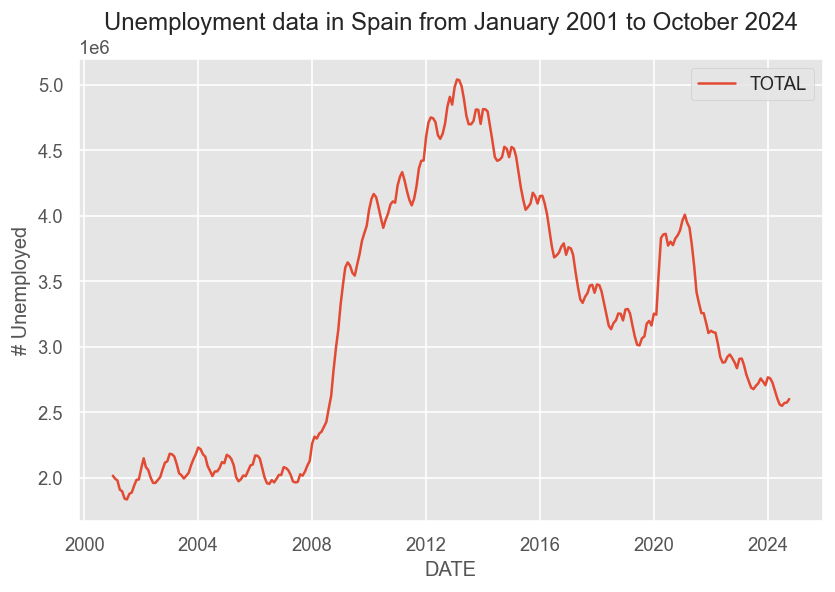

In [3]:
# Plot data
fig, ax = plt.subplots()
ax.plot("TOTAL", data=df)
ax.set(
    title="Unemployment data in Spain from January 2001 to October 2024",
    xlabel="DATE",
    ylabel="# Unemployed",
)
plt.legend()
plt.show()

We can see how the Great Recession in 2008 and the COVID-19 crisis in 2020 have a big impact on the unemployment rate in Spain.

In [4]:
df_ts = df[["TOTAL"]]/1e6
df_ts

TOTAL
DATE                
2001-01-01  2.017389
2001-02-01  1.993273
2001-03-01  1.981006
2001-04-01  1.910453
2001-05-01  1.898285
...              ...
2024-06-01  2.561067
2024-07-01  2.550237
2024-08-01  2.572121
2024-09-01  2.575285
2024-10-01  2.602054

[286 rows x 1 columns]

### **Plot the series and search for possible outliers**

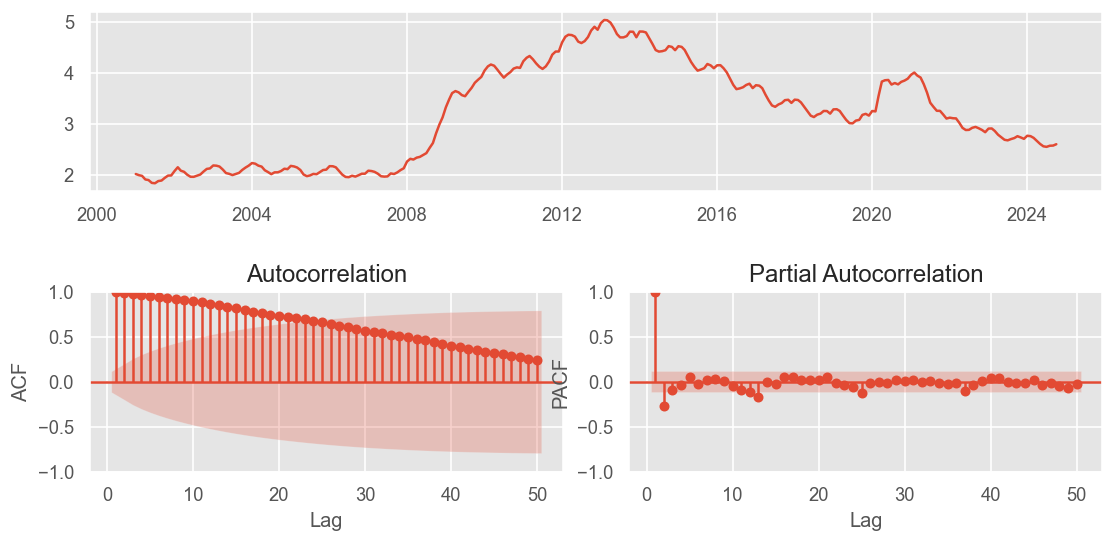

In [5]:
# ACF and PACF of the time series -> identify significant lags and order
ts_display(df_ts, lags=50)

We observe that the ACF and PACF are not stationary, so we'll need to difference the series, both in regular and seasonal terms.

---
## **a) Identify the best Seasonal ARIMA model to forecast the total unemployment rate**

### **Stabilize the variance (if needed) -> BoxCox only works for lineal dependency sigma vs mu**

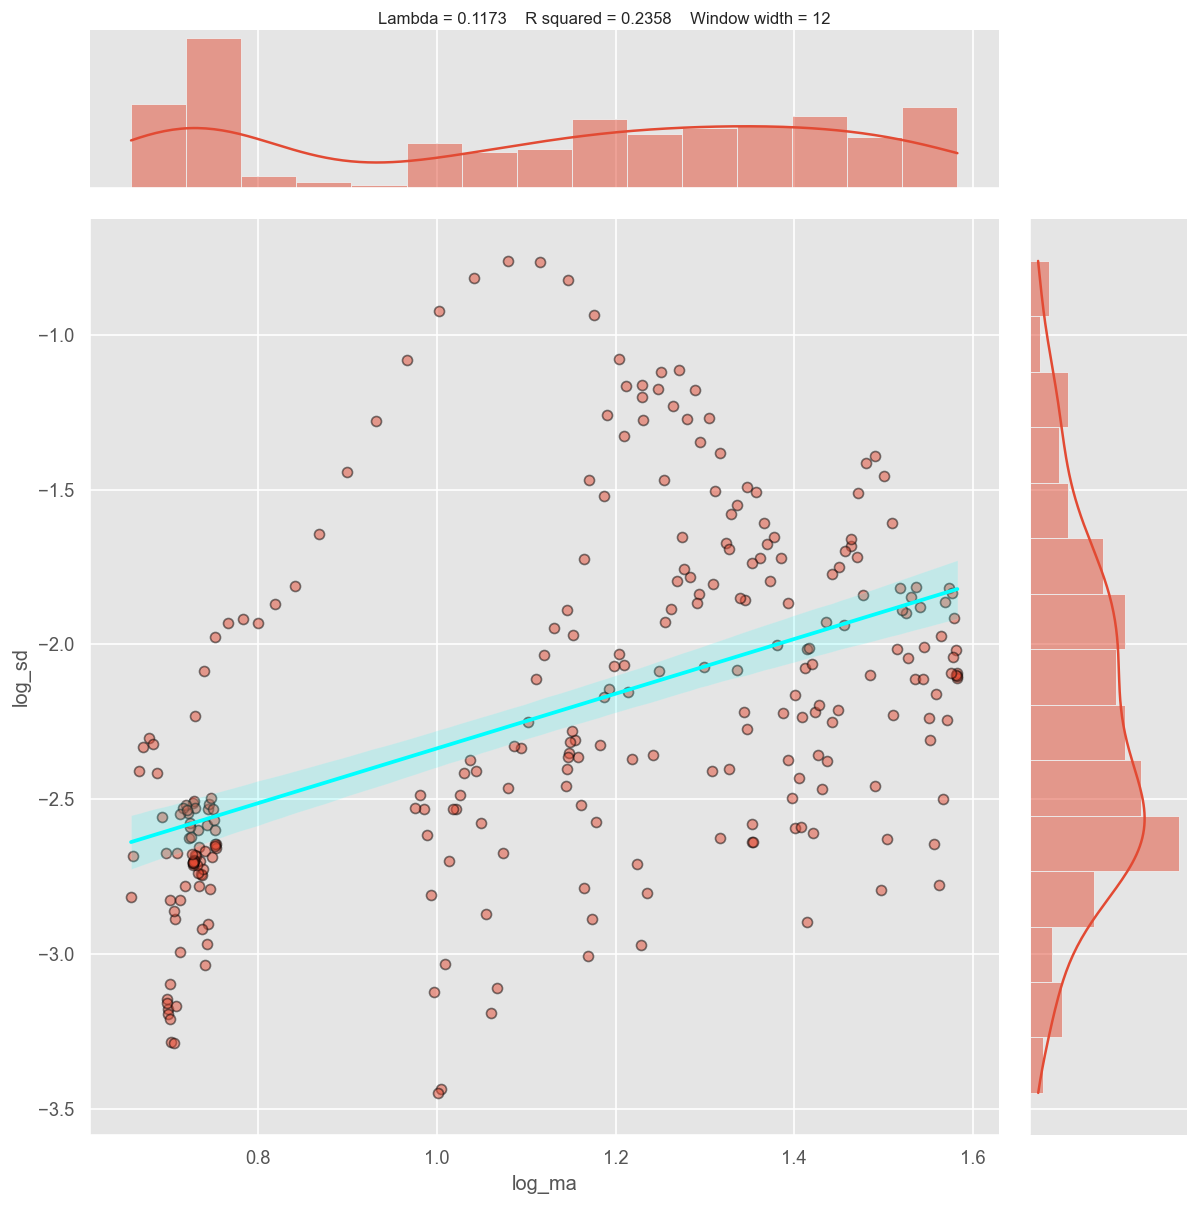

0.11727447888210618

In [6]:
# Box-Cox transformation --> Significant if R squared greater than 0.4
boxcox_lambda_plot(df_ts, window_width=12)
# window_width = 12 because the unemployment data is monthly, so we can expect a yearly seasonality

In this case, R squared is less than 0.4, so we will not apply the Box-Cox transformation, not needed.

### **Analyze stationarity**

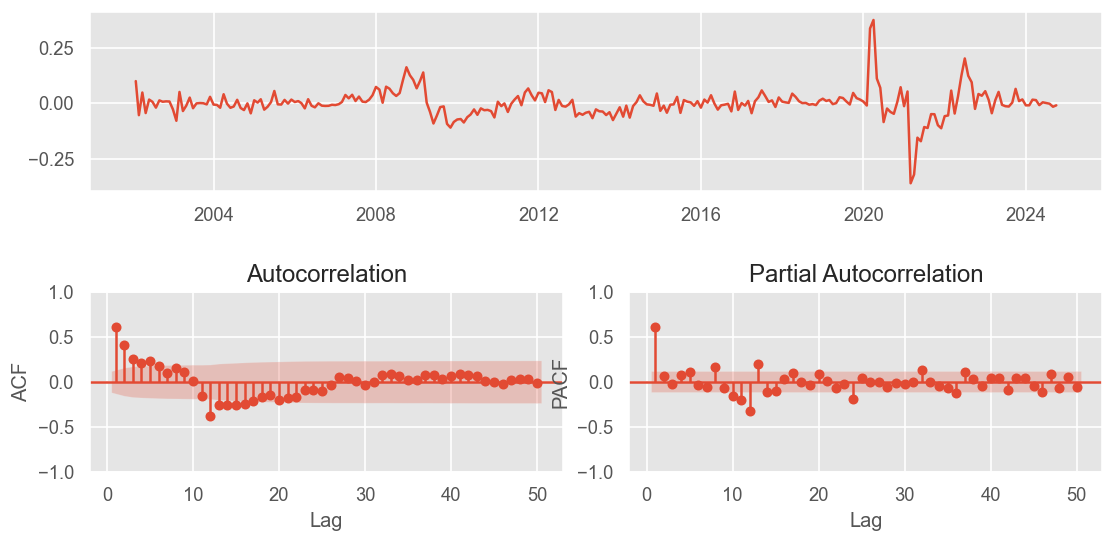

In [7]:
# Difference of the time series
d = 1  # y(t) - y(t-1) -> regular differencing
D = 1  # y(t) - y(t-s) -> seasonal differencing
S = 12  # Seasonality of 12 days

z = df_ts  # for simplicity in the next steps

Bz = z
for diff in range(d):
    Bz = Bz.diff().dropna()  # drop first NA value
for seas_diff in range(D):
    Bz = Bz.diff(S).dropna()  # drop first NA values
ts_display(Bz, lags=50)

# 1. First, we see that a regular differencing of d>=1 is needed to make the series stationary.
# 2. We also see that there is a seasonal pattern every 12 months and no stationary in seasonal also, so S = 12 and D = 1 -> S = 12, D = 1

### **Fit ARIMA model and check significance of the coefficients**

In [8]:
# Fit model with estimated order
sarima_fit = SARIMAX(
    z,
    # First, we observe the regular order
    order=(1, 1, 0),  # Regular components -> (p, d, q) -> p = 1, d = 2, q = 1
    # Second, we observe the seasonal order
    seasonal_order=(
        0,
        1,
        1,
        12,
    ),  # Seasonal components -> (P, D, Q, S) -> P = 1, D = 1, Q = 1, S = 12
    trend="n",  # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
).fit()

print(sarima_fit.summary())

/opt/miniconda3/envs/ML1/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/miniconda3/envs/ML1/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.62205D+00    |proj g|=  4.87312D+00

At iterate    5    f= -1.64124D+00    |proj g|=  4.89173D-01

At iterate   10    f= -1.66990D+00    |proj g|=  2.50543D+00

At iterate   15    f= -1.67647D+00    |proj g|=  2.47481D-02

At iterate   20    f= -1.67648D+00    |proj g|=  7.77778D-02

At iterate   25    f= -1.67652D+00    |proj g|=  2.68428D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     34      1     0     0   

- In the summary we can see the AIC and BIC values, the lower the better.
- We can also see the p-values of the coefficients, in this case all of them are significant.

### **Analyze residuals**

Ljung-Box test of residuals:
     lb_stat  lb_pvalue
50  45.13031   0.668747


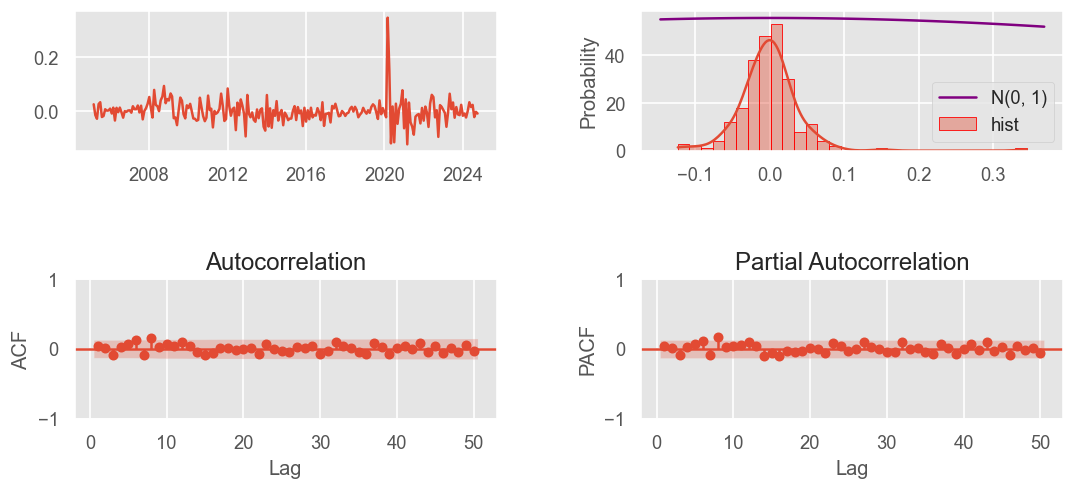

In [9]:
# Plot residual error
date_50 = df.index[50]  # We have chosen to see the residuals from the 50th month
check_residuals(pd.DataFrame(sarima_fit.resid.loc[date_50:]), lags=50)

We can observe that the residuals aren't stationary, maybe due to outliers because of the COVID-19 crisis in 2020, so we can try to fit the model trying to avoid these outliers or using an intervention variable.

[]

<Figure size 960x600 with 0 Axes>

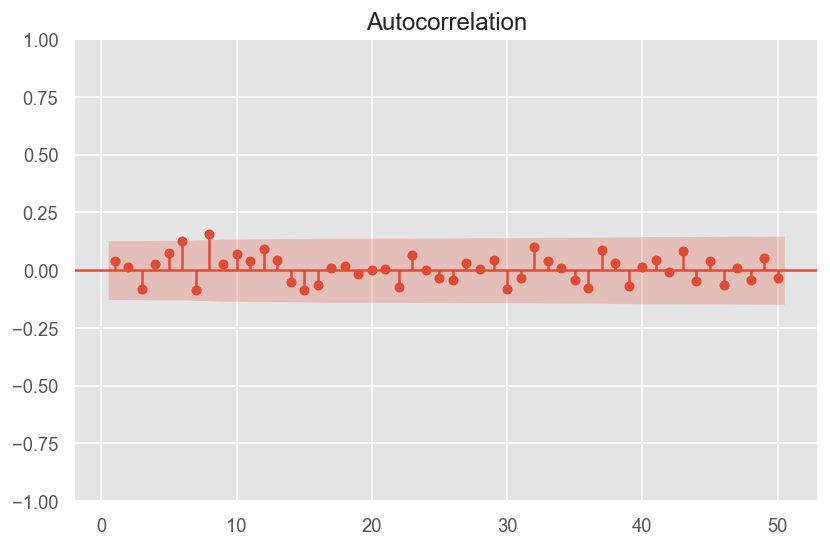

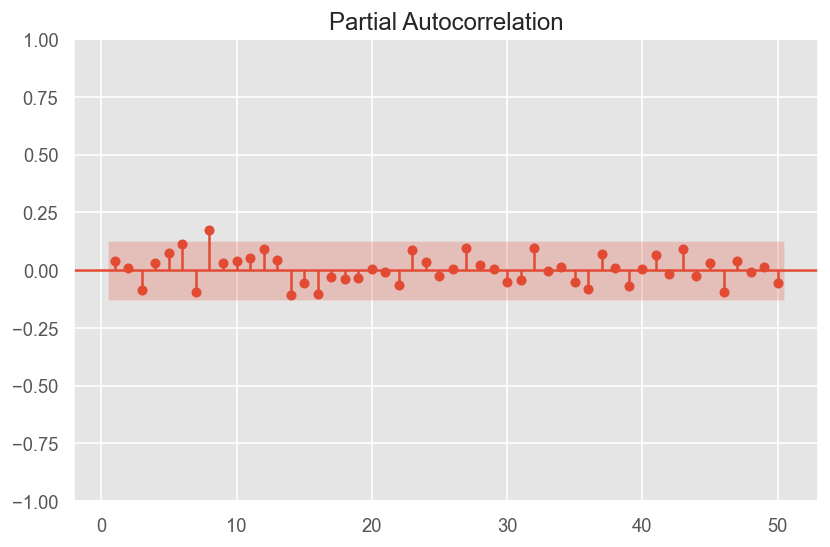

In [10]:
# Bigger plots to check residuals
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure()
plot_acf(sarima_fit.resid.loc[date_50:], lags=50, zero=False)
plt.plot()
plot_pacf(sarima_fit.resid.loc[date_50:], lags=50, zero=False)
plt.plot()

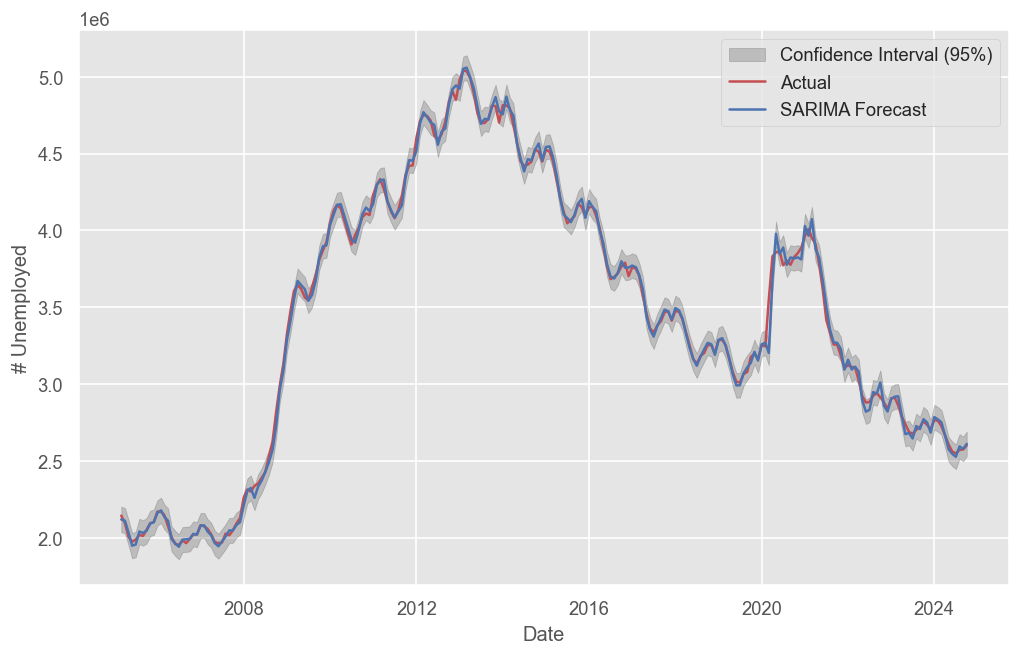

In [11]:
# Define start and end points using dates instead of numeric indices
start_date = df_ts.index[50]  # Date corresponding to the 50th point
horizon = 0
end_date = df_ts.index[-1] + pd.DateOffset(
    horizon
)  # Date corresponding to the last point + horizon

# Obtain forecasts for in-sample and out-of-sample
pred_SARIMA = sarima_fit.get_prediction(start=start_date, end=end_date, dynamic=False)
yhat_SARIMA = pred_SARIMA.predicted_mean*1e6
yhat_conf_int_SARIMA = pred_SARIMA.conf_int(alpha=0.05)*1e6


# Plot forecasts with confidence intervals
plt.figure(figsize=(10, 6))
plt.fill_between(
    yhat_conf_int_SARIMA.index,
    yhat_conf_int_SARIMA.iloc[:, 0],
    yhat_conf_int_SARIMA.iloc[:, 1],
    color="k",
    alpha=0.2,
    label="Confidence Interval (95%)",
)
plt.plot(df_ts["TOTAL"].loc[start_date:]*1e6, label="Actual", c="r")
plt.plot(yhat_SARIMA, label="SARIMA Forecast", color="b")
plt.xlabel("Date")
plt.ylabel("# Unemployed")
plt.legend()
plt.show()

Covid analysis in detail

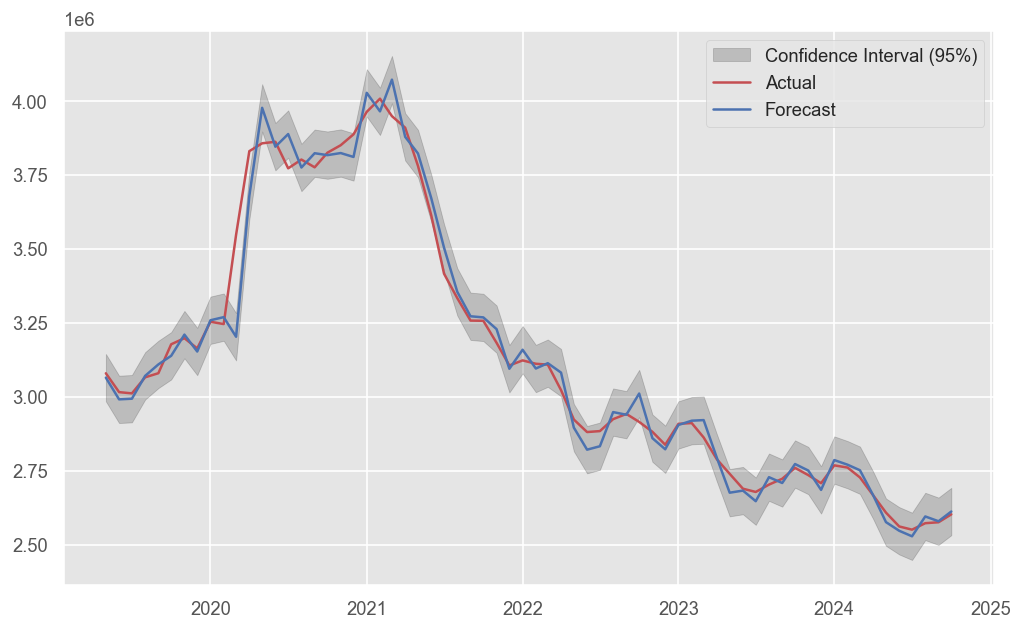

In [12]:
# Define start and end points using dates instead of numeric indices
start_date = df_ts.index[
    220
]  # Date corresponding to the 220th point for better visualization of COVID period
horizon = 0
end_date = df_ts.index[-1] + pd.DateOffset(
    horizon
)  # Date corresponding to the last point + horizon

# Obtain forecasts for in-sample and out-of-sample
pred_SARIMA = sarima_fit.get_prediction(start=start_date, end=end_date, dynamic=False)
yhat_SARIMA = pred_SARIMA.predicted_mean*1e6
yhat_conf_int_SARIMA = pred_SARIMA.conf_int(alpha=0.05)*1e6

# Plot forecasts with confidence intervals
plt.figure(figsize=(10, 6))
plt.fill_between(
    yhat_conf_int_SARIMA.index,
    yhat_conf_int_SARIMA.iloc[:, 0],
    yhat_conf_int_SARIMA.iloc[:, 1],
    color="k",
    alpha=0.2,
    label="Confidence Interval (95%)",
)
plt.plot(df_ts["TOTAL"].loc[start_date:]*1e6, label="Actual", c="r")
plt.plot(yhat_SARIMA, label="Forecast", color="b")
plt.legend()
plt.show()

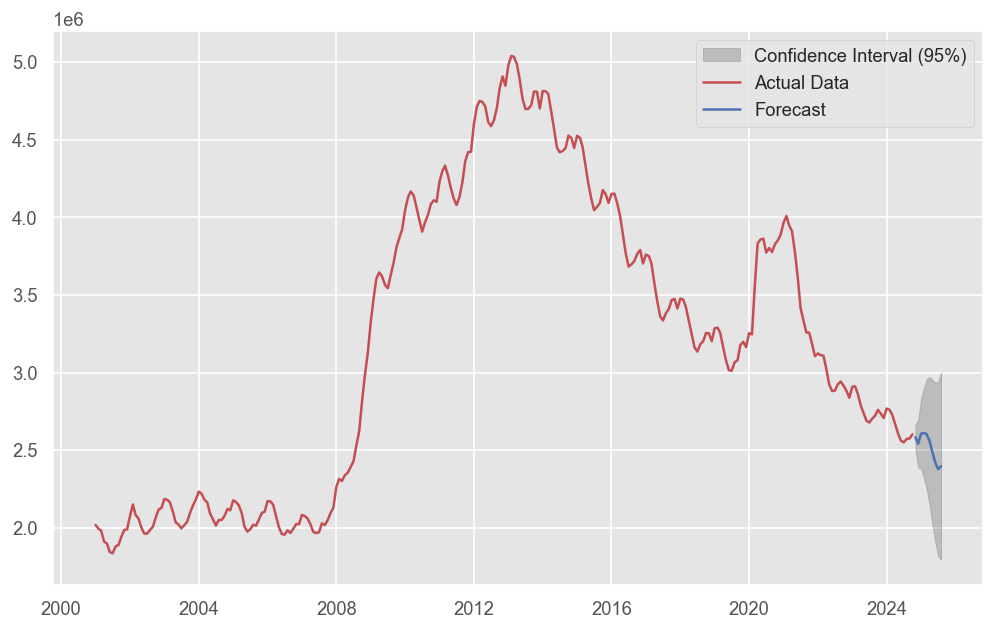

In [13]:
# Define horizon for out-of-sample forecast
horizon = 10
end_date = df_ts.index[-1] + pd.DateOffset(
    horizon
)  # Date corresponding to the last point + horizon

# Obtain out-of-sample forecast using SARIMAX model
pred_SARIMA = sarima_fit.get_forecast(steps=horizon, dynamic=False)
yhat_SARIMA = pred_SARIMA.predicted_mean*1e6
yhat_conf_int_SARIMA = pred_SARIMA.conf_int(alpha=0.05)*1e6

# Plot the forecast with confidence intervals
plt.figure(figsize=(10, 6))
plt.fill_between(
    yhat_conf_int_SARIMA.index,
    yhat_conf_int_SARIMA.iloc[:, 0],
    yhat_conf_int_SARIMA.iloc[:, 1],
    color="k",
    alpha=0.2,
    label="Confidence Interval (95%)",
)

# Plot the actual data until the forecast starts, and then the forecasted values
plt.plot(df_ts["TOTAL"]*1e6, label="Actual Data", c="r")
plt.plot(yhat_SARIMA.index, yhat_SARIMA, label="Forecast", color="b")

plt.legend()
plt.show()

Forecast could be improved by including an intervention variable that accounts for the COVID-19 crisis or eliminating the outliers that affect the model.

Also, maybe the model could be affected by some external variables unkown at the moment related to the DANA crisis in Valencia.

## **b) Identify the best `SARIMAX` model to forecast the total unemployment rate accounting for the `COVID-19` period using an intervention variable**

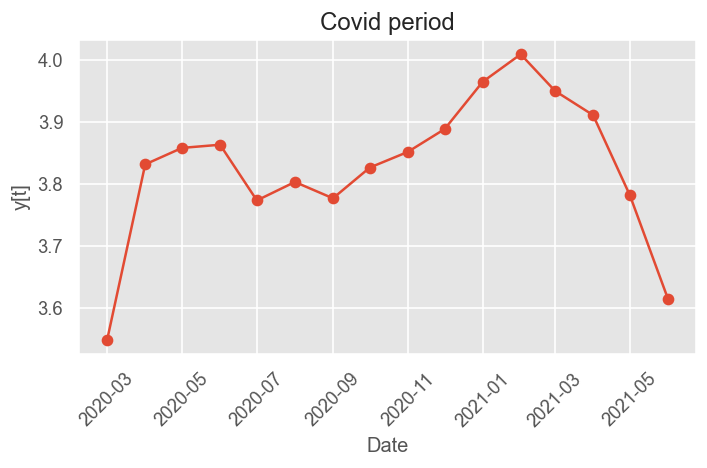

In [14]:
# Filter the DataFrame for the specified date range
df_cut = df_ts.loc["2020-03-01":"2021-06-01"]

# We consider the COVID-19 period from '2020-03-01', when the unemployment started to increase as the disease appeared (see plot below)
# to '2021-06-01', when the business re-opened and all the restrictive measures stopped.

# Plotting the subset of the time series
plt.figure(figsize=(6, 4))
plt.plot(
    df_cut.index, df_cut.values, marker="o"
)  # Use df_cut.index as the x-axis (dates)
plt.title("Covid period")
plt.xlabel("Date")
plt.ylabel("y[t]")
plt.grid(True)
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

### COVID variable as step function

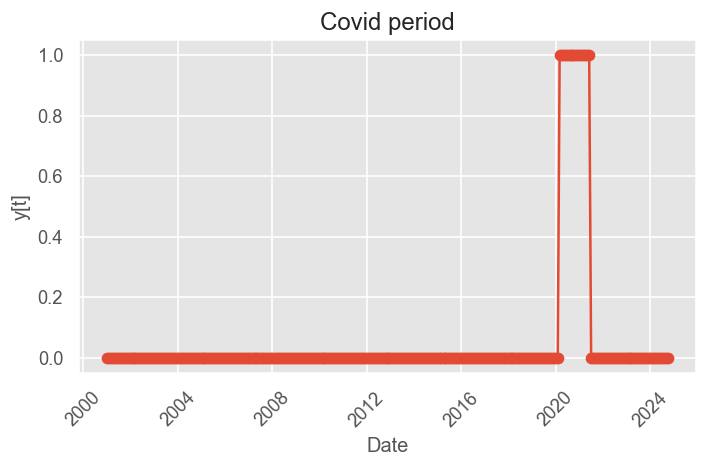

In [15]:
# Create a new variable 'COVID': 1 during the COVID period, 0 elsewhere
df_ts["COVID"] = ((df_ts.index >= "2020-03-01") & (df_ts.index <= "2021-06-01")).astype(
    int
)

# Plotting the subset of the time series
plt.figure(figsize=(6, 4))
plt.plot(
    df_ts.index, df_ts["COVID"], marker="o"
)  # Use df_cut.index as the x-axis (dates)
plt.title("Covid period")
plt.xlabel("Date")
plt.ylabel("y[t]")
plt.grid(True)
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

### COVID variable as a normal distribution

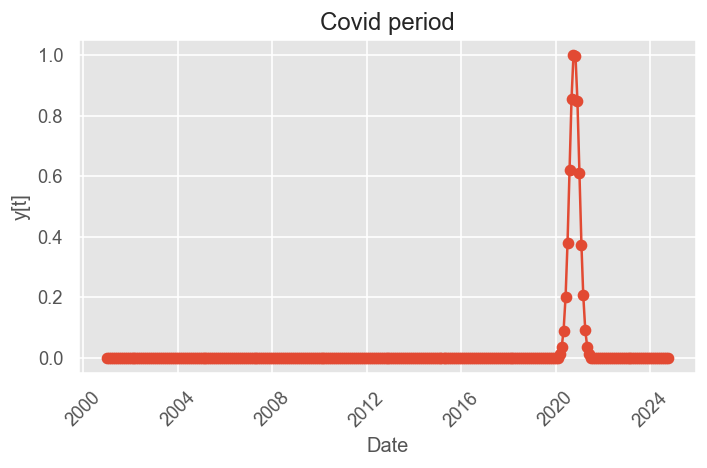

In [16]:
from scipy.stats import norm

# Define the start and end dates of the COVID period
start = pd.Timestamp("2020-03-01")
end = pd.Timestamp("2021-06-01")

# Calculate the midpoint of the COVID period
mid_point = start + (end - start) / 2

# Calculate total duration of the period in days
total_duration = (end - start).days

# Set standard deviation to create a smooth Gaussian curve
# Divided by 6 to cover approximately 99% of the period
std_dev = total_duration / 6

# Create Gaussian variable with smooth transition
# Uses the number of days from midpoint to calculate PDF
df_ts["COVID"] = df_ts.index.map(
    lambda x: norm.pdf((x - mid_point).days, loc=0, scale=std_dev)
)

# Set values to 0 outside the specified date range
df_ts.loc[(df_ts.index < start) | (df_ts.index > end), "COVID"] = 0

# Normalize values so the maximum is 1
df_ts["COVID"] = df_ts["COVID"] / df_ts["COVID"].max()

# Plotting the subset of the time series
plt.figure(figsize=(6, 4))
plt.plot(
    df_ts.index, df_ts["COVID"], marker="o"
)  # Use df_cut.index as the x-axis (dates)
plt.title("Covid period")
plt.xlabel("Date")
plt.ylabel("y[t]")
plt.grid(True)
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

### COVID variable as a $\chi^2$ distribution

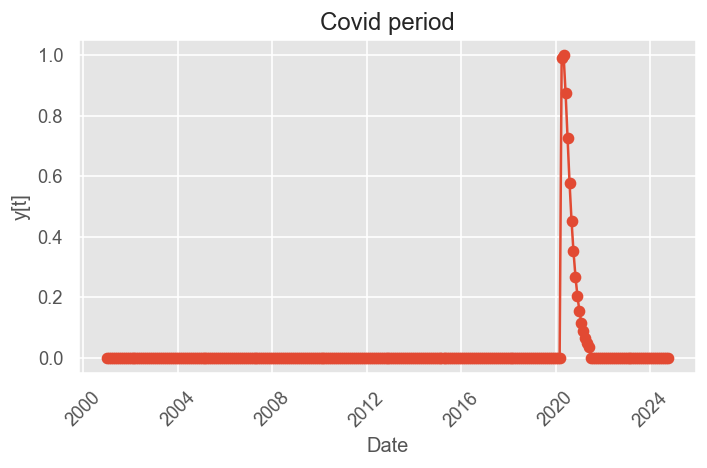

In [17]:
from scipy.stats import chi2

# Define the start and end dates of the COVID period
start = pd.Timestamp("2020-03-01")
end = pd.Timestamp("2021-06-01")

# Calculate total duration of the period in days
total_duration = (end - start).days

# Normalize the x-axis to be between 0 and 1
df_ts["days_normalized"] = (df_ts.index - start) / (end - start)

# Create chi-square distributed variable
# Use 3 degrees of freedom for a skewed but bounded distribution
df_ts["COVID"] = chi2.pdf(df_ts["days_normalized"] * 10, df=3)

# Set values to 0 outside the specified date range
df_ts.loc[(df_ts.index < start) | (df_ts.index > end), "COVID"] = 0

# Normalize values so the maximum is 1
df_ts["COVID"] = df_ts["COVID"] / df_ts["COVID"].max()

# Plotting the subset of the time series
plt.figure(figsize=(6, 4))
plt.plot(df_ts.index, df_ts["COVID"], marker="o")  # Use df.index as the x-axis (dates)
plt.title("Covid period")
plt.xlabel("Date")
plt.ylabel("y[t]")
plt.grid(True)
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

We'll choose COVID variable as a $\chi^2$ distribution because MAPE error is the lowest, check c) for more details on metrics.

### Train SARIMAX model

In [18]:
# At the moment this is all we have
X = df_ts["COVID"]
y = df_ts["TOTAL"]

In [19]:
# We could also fit a more complicated model with ARMA with seasonal components.
mod_sarimax = sm.tsa.SARIMAX(
    endog=y,  # This is our output variable
    order=(1, 1, 0),
    seasonal_order=(0, 1, 1, 12),
    trend="n",
    exog=X,
)  # This is our input variable
res_sarimax = mod_sarimax.fit()

# Show the summary of results
print(res_sarimax.summary())

/opt/miniconda3/envs/ML1/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/miniconda3/envs/ML1/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.62767D+00    |proj g|=  5.34343D+00

At iterate    5    f= -1.65217D+00    |proj g|=  5.25069D-01

At iterate   10    f= -1.68332D+00    |proj g|=  1.47887D+00

At iterate   15    f= -1.69356D+00    |proj g|=  2.97480D+00

At iterate   20    f= -1.71295D+00    |proj g|=  1.20730D-01

At iterate   25    f= -1.71692D+00    |proj g|=  8.37318D-01

At iterate   30    f= -1.71767D+00    |proj g|=  4.52523D-02

At iterate   35    f= -1.71769D+00    |proj g|=  8.58989D-03
  ys=-1.551E-06  -gs= 7.012E-07 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of 

Ljung-Box test of residuals:
      lb_stat  lb_pvalue
50  47.487365   0.574792


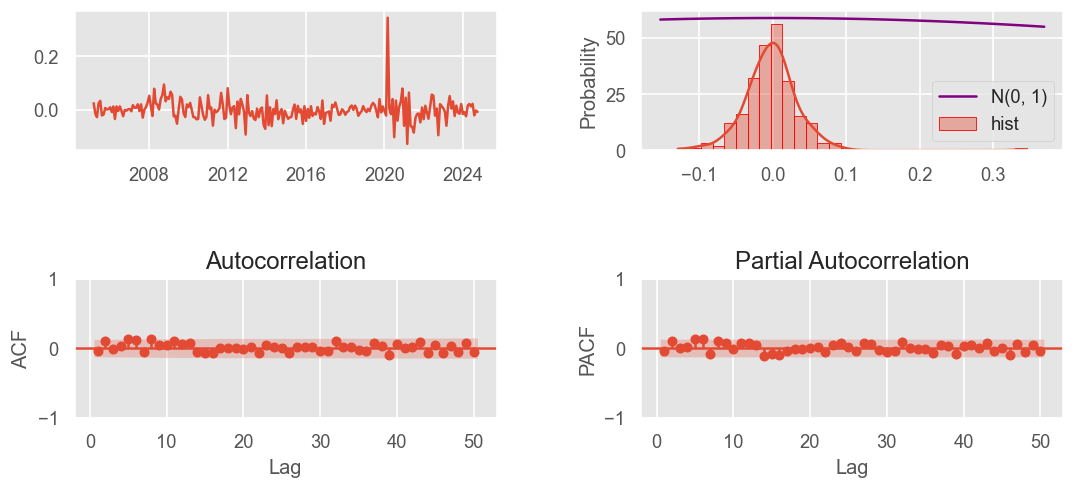

In [20]:
# Plot residual error
date_50 = df_ts.index[50]
check_residuals(pd.DataFrame(res_sarimax.resid.loc[date_50:]), lags=50)

<Figure size 960x600 with 0 Axes>

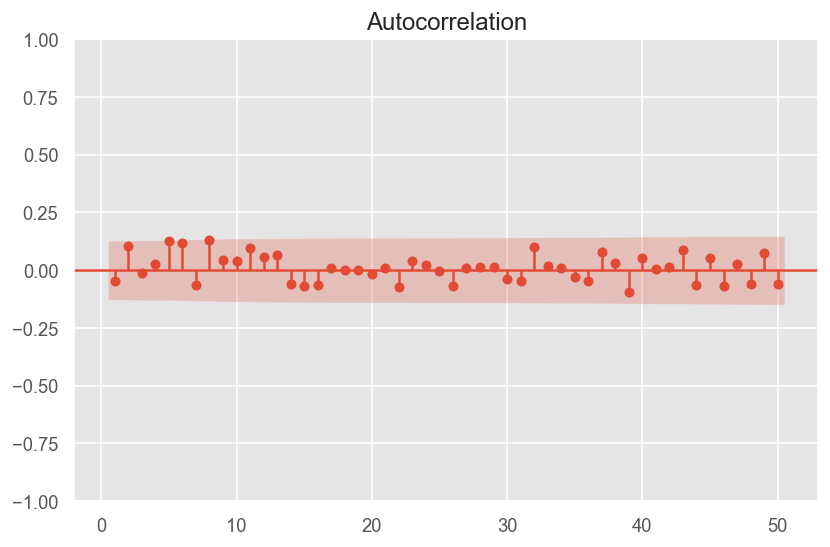

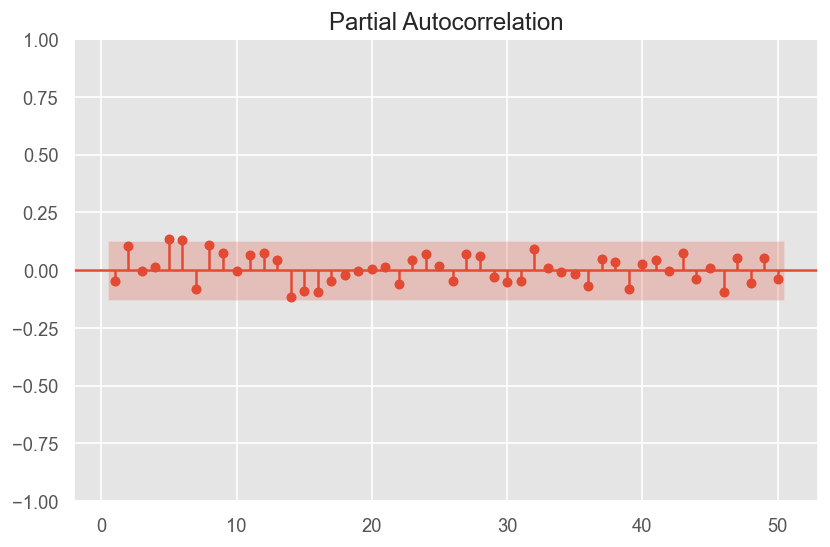

In [21]:
# Bigger plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure()
plot_acf(res_sarimax.resid.loc[date_50:], lags=50, zero=False)
plot_pacf(res_sarimax.resid.loc[date_50:], lags=50, zero=False);

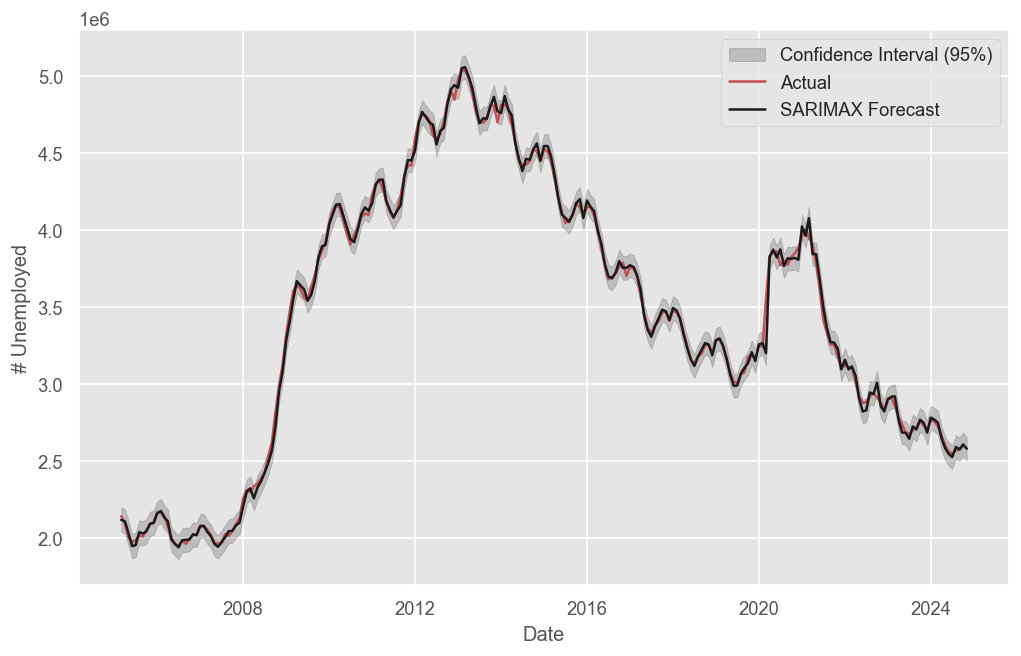

In [22]:
# Define start and end points using dates instead of numeric indices
start_date = df_ts.index[50]  # 50th point
horizon = 10
end_date = df_ts.index[-1] + pd.DateOffset(
    horizon
)  # Fecha del último punto más horizonte

# Obtain forecasts for in-sample and out-of-sample
pred_SARIMAX = res_sarimax.get_prediction(
    start=start_date, end=end_date, exog=X[0:1], dynamic=False
)
yhat_SARIMAX = pred_SARIMAX.predicted_mean*1e6
yhat_conf_int_SARIMAX = pred_SARIMAX.conf_int(alpha=0.05)*1e6

# Plot forecasts with confidence intervals
plt.figure(figsize=(10, 6))
plt.fill_between(
    yhat_conf_int_SARIMAX.index,
    yhat_conf_int_SARIMAX.iloc[:, 0],
    yhat_conf_int_SARIMAX.iloc[:, 1],
    color="k",
    alpha=0.2,
    label="Confidence Interval (95%)",
)
plt.plot(df_ts["TOTAL"].loc[start_date:]*1e6, label="Actual", c="r")
plt.plot(yhat_SARIMAX, label="SARIMAX Forecast", color="k")
plt.legend()
plt.xlabel("Date")
plt.ylabel("# Unemployed")
plt.show()

## **c) Compare both models**

In [23]:
start_date = '2019-05-01' # From COVID period (test data in MLP model)
end_date = df_ts.index[-1]

# SARIMAX
pred_sarimax = res_sarimax.get_prediction(
    start=start_date, end=end_date, exog=X[0:1], dynamic=False
)
yhat_sarimax = pred_sarimax.predicted_mean*1e6
yhat_sarimax_conf = pred_sarimax.conf_int(alpha=0.05)*1e6

# SARIMA
pred_sarima = sarima_fit.get_prediction(start=start_date, end=end_date, dynamic=False)
yhat_sarima = pred_sarima.predicted_mean*1e6
yhat_sarima_conf = pred_sarima.conf_int(alpha=0.05)*1e6

y_actual = df_ts["TOTAL"][start_date:end_date]*1e6

# Metrics
mae_sarimax = mean_absolute_error(y_actual, yhat_sarimax)
rmse_sarimax = mean_squared_error(y_actual, yhat_sarimax, squared=False)

mae_sarima = mean_absolute_error(y_actual, yhat_sarima)
rmse_sarima = mean_squared_error(y_actual, yhat_sarima, squared=False)

mape_sarimax = mean_absolute_percentage_error(y_actual, yhat_sarimax)*100
mape_sarima = mean_absolute_percentage_error(y_actual, yhat_sarima) *100

r2_sarimax = r2_score(y_actual, yhat_sarimax)
r2_sarima = r2_score(y_actual, yhat_sarima)

print(
    f"SARIMAX - MAE: {mae_sarimax:.2f}, RMSE: {rmse_sarimax:.2f}",
    f"MAPE: {mape_sarimax:.2f} %",
    f"R2: {r2_sarimax:.4f}",
)
print(
    f"SARIMA  - MAE: {mae_sarima:.2f}, RMSE: {rmse_sarima:.2f}",
    f"MAPE: {mape_sarima:.2f} %",
    f"R2: {r2_sarima:.4f}",
)

SARIMAX - MAE: 34851.63, RMSE: 58195.51 MAPE: 1.06 % R2: 0.9826
SARIMA  - MAE: 38033.25, RMSE: 62613.83 MAPE: 1.15 % R2: 0.9798


/opt/miniconda3/envs/ML1/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/miniconda3/envs/ML1/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [24]:
start_date = df_ts.index[220]  # From COVID period
print(df_ts.loc['2021-09-01'])
print("\n")
print(start_date)

TOTAL              3.257802
COVID              0.000000
days_normalized    1.201313
Name: 2021-09-01 00:00:00, dtype: float64


2019-05-01 00:00:00


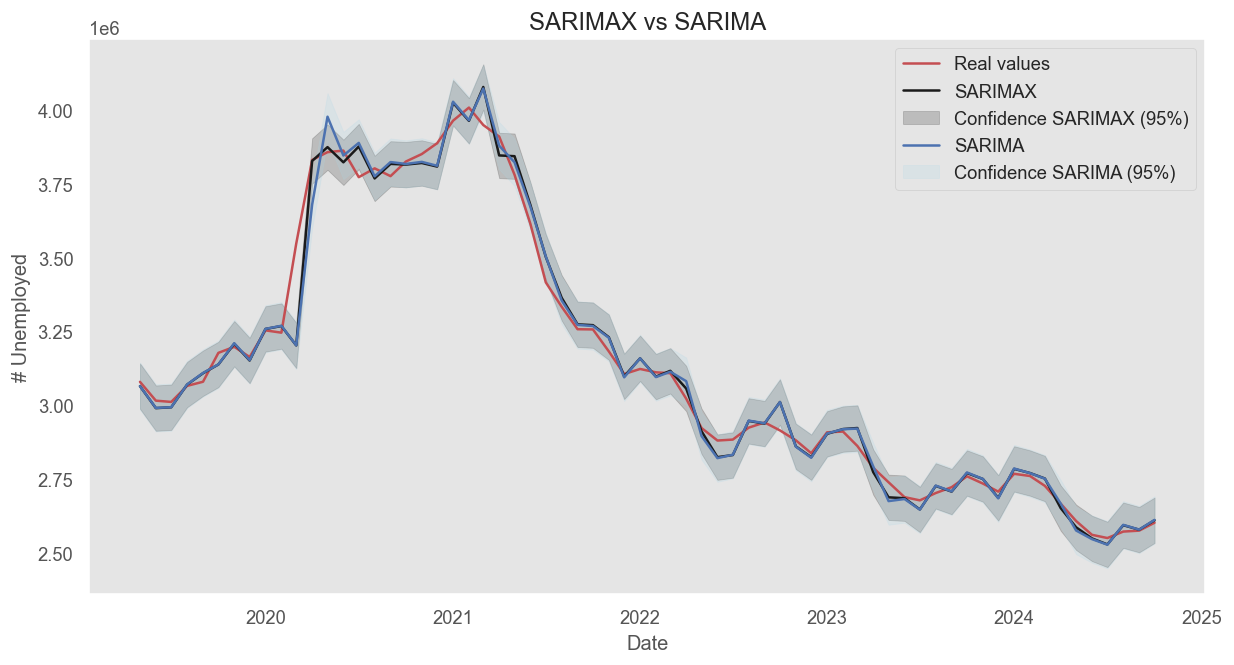

In [25]:
plt.figure(figsize=(12, 6))

plt.plot(y_actual, label="Real values", color="r")

# Gráfica de predicciones SARIMAX
plt.plot(yhat_sarimax, label="SARIMAX", color="k")
plt.fill_between(
    yhat_sarimax_conf.index,
    yhat_sarimax_conf.iloc[:, 0],
    yhat_sarimax_conf.iloc[:, 1],
    color="k",
    alpha=0.2,
    label="Confidence SARIMAX (95%)",
)

# Gráfica de predicciones SARIMA
plt.plot(yhat_sarima, label="SARIMA", color="b")
plt.fill_between(
    yhat_sarima_conf.index,
    yhat_sarima_conf.iloc[:, 0],
    yhat_sarima_conf.iloc[:, 1],
    color="lightblue",
    alpha=0.2,
    label="Confidence SARIMA (95%)",
)

# Configuración del gráfico
plt.title("SARIMAX vs SARIMA")
plt.xlabel("Date")
plt.ylabel("# Unemployed")
plt.legend()
plt.grid()
plt.show()


## **d) Apply nonlinear techniques for forecasting the unemployment**

In [26]:
### Include lagged variables and COVID
dfT = df_ts[["TOTAL", "COVID"]].copy()

# dfT["COVID"] = dfT["COVID"].astype("category")

dfT["TOTAL_lag1"] = df_ts["TOTAL"].shift()  # TOTAL (t-1)
dfT["TOTAL_lag2"] = df_ts["TOTAL"].shift(2)  # TOTAL (t-2)
dfT["TOTAL_lag12"] = df_ts["TOTAL"].shift(12)  # TOTAL (t-12)
dfT["TOTAL_lag24"] = df_ts["TOTAL"].shift(24)  # TOTAL (t-24) -> no sé si es necesario

dfT.head()

TOTAL  COVID  TOTAL_lag1  TOTAL_lag2  TOTAL_lag12  TOTAL_lag24
DATE                                                                         
2001-01-01  2.017389    0.0         NaN         NaN          NaN          NaN
2001-02-01  1.993273    0.0    2.017389         NaN          NaN          NaN
2001-03-01  1.981006    0.0    1.993273    2.017389          NaN          NaN
2001-04-01  1.910453    0.0    1.981006    1.993273          NaN          NaN
2001-05-01  1.898285    0.0    1.910453    1.981006          NaN          NaN

In [27]:
# Remove missing
dfT.dropna(inplace=True)
dfT.head()

TOTAL  COVID  TOTAL_lag1  TOTAL_lag2  TOTAL_lag12  TOTAL_lag24
DATE                                                                         
2003-01-01  2.185156    0.0    2.127018    2.117144     2.075022     2.017389
2003-02-01  2.180216    0.0    2.185156    2.127018     2.149907     1.993273
2003-03-01  2.163499    0.0    2.180216    2.185156     2.083103     1.981006
2003-04-01  2.104474    0.0    2.163499    2.180216     2.060069     1.910453
2003-05-01  2.035601    0.0    2.104474    2.163499     2.002923     1.898285

In [28]:
# Define input and output matrices
INPUTS = ["COVID", "TOTAL_lag1", "TOTAL_lag2", "TOTAL_lag12", "TOTAL_lag24"]
OUTPUT = ["TOTAL"]

# We have categorical inputs with many classes. We will create dummy variables automatically after
X = dfT[INPUTS]
y = dfT[OUTPUT]

In [29]:
## Divide the data into training and test sets SEQUENTIALY -------------------------------------
# Create random 80/20 % split
X_train = X.iloc[2 : round(0.85 * X.shape[0])]
X_test = X.iloc[round(0.85 * X.shape[0]) + 1 : X.shape[0]]
y_train = y.iloc[2 : round(0.85 * X.shape[0])]
y_test = y.iloc[round(0.85 * X.shape[0]) + 1 : X.shape[0]]


## Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTR_eval["TOTAL"] = y_train  # We will call Y as output variable for simplicity
dfTS_eval = X_test.copy()
dfTS_eval["TOTAL"] = y_test  # We will call Y as output variable for simplicity

X_train.head()

COVID  TOTAL_lag1  TOTAL_lag2  TOTAL_lag12  TOTAL_lag24
DATE                                                               
2003-03-01    0.0    2.180216    2.185156     2.083103     1.981006
2003-04-01    0.0    2.163499    2.180216     2.060069     1.910453
2003-05-01    0.0    2.104474    2.163499     2.002923     1.898285
2003-06-01    0.0    2.035601    2.104474     1.962963     1.842556
2003-07-01    0.0    2.020367    2.035601     1.961852     1.835738

In [30]:
# ------------------------------- MLP Regression MODEL -------------------------------------------------
## Inputs of the model. Change accordingly to perform variable selection
INPUTS_MLP_NUM = ["COVID", "TOTAL_lag1", "TOTAL_lag2", "TOTAL_lag12", "TOTAL_lag24"]
INPUTS_MLP_CAT = []
INPUTS_MLP = INPUTS_MLP_NUM + INPUTS_MLP_CAT

# numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])

# # Prepare the categorical variables by encoding the categories
# categorical_transformer = Pipeline(
#     steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))]
# )

# # Create a preprocessor to perform the steps defined above
# preprocessor = ColumnTransformer(
#     transformers=[
#         ("num", numeric_transformer, INPUTS_MLP_NUM),
#         ("cat", categorical_transformer, INPUTS_MLP_CAT),
#     ]
#)

"""
param = {
    # Valores ampliados para la regularización (alpha)
    'MLP__alpha': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0],
    
    # Diversidad en tamaños de capas ocultas
    'MLP__hidden_layer_sizes': [
        (1,), (2,), (3,), (4,), (5,), (10,),  # Capas únicas con más neuronas
        (1, 1), (2, 2), (3, 3), (5, 5),  # Capas dobles
        (2, 1), (3, 2),  # Capas decrecientes
        (2, 2, 2), (3, 3, 3), (5, 5, 5), (10, 10, 10), (20, 20, 20), (50, 50, 50)],
    
    # Función de activación
    'MLP__activation': ['identity', 'tanh', 'relu'],  # Funciones de activación disponibles
    
    # Método de optimización (solver)
    'MLP__solver': ['lbfgs', 'adam', 'sgd'],  # Solvers disponibles
    
    # Tolerancia para la optimización
    'MLP__tol': [1e-5, 1e-4, 1e-3, 1e-2],  # Tolerancias para la convergencia
    
    # Número máximo de iteraciones
    'MLP__max_iter': [500]  # Iteraciones máximas
}


"""
## GOOD PARAMS

param = {
    "MLP__activation": ["relu"],
    "MLP__alpha": [0.01],
    "MLP__hidden_layer_sizes": [(5, 5, 5)],
    "MLP__max_iter": [500],
    "MLP__solver": ["lbfgs"],
    "MLP__tol": [1e-05],
}


pipe = Pipeline(
    [
        #("preprocessor", preprocessor),
        ("MLP", MLPRegressor(random_state=150, verbose=True)),
    ]
)  # For replication

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined
nFolds = 10
MLP_fit = GridSearchCV(
    estimator=pipe,  # Structure of the model to use
    param_grid=param,  # Defined grid to search in
    n_jobs=-1,  # Number of cores to use (parallelize)
    scoring="neg_mean_absolute_percentage_error",  # MAPE https://scikit-learn.org/stable/modules/model_evaluation.html
    cv=nFolds,
)  # Number of Folds
MLP_fit.fit(X_train[INPUTS_MLP], y_train)  # Search in grid

/opt/miniconda3/envs/ML1/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 This problem is unconstrained.
/opt/miniconda3/envs/ML1/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 This problem is unconstrained.
/opt/miniconda3/envs/ML1/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 This problem is unconstrained.
/opt/minic

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           96     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.26023D+01    |proj g|=  1.60200D+01

At iterate    1    f=  7.17344D+00    |proj g|=  3.67578D+00

At iterate    2    f=  6.41548D+00    |proj g|=  3.46380D+00

At iterate    3    f=  1.41216D+00    |proj g|=  1.39512D+00

At iterate    4    f=  4.72670D-01    |proj g|=  3.27969D-01

At iterate    5    f=  4.48632D-01    |proj g|=  3.21527D-01

At iterate    6    f=  4.22193D-01    |proj g|=  9.73361D-02

At iterate    7    f=  4.16459D-01    |proj g|=  2.46531D-02

At iterate    8    f=  4.16196D-01    |proj g|=  6.96504D-03

At iterate    9    f=  4.16020D-01    |proj g|=  1.73128D-03

At iterate   10    f=  4.16014D-01    |proj g|=  7.10416D-04

At iterate   11    f=  4.16014D-01    |proj g|=  3.90622D-05

At iterate   12    f=  4.16014D-01    |proj g|=  8.88354D-05

At iterate   13    f=  4.1

 This problem is unconstrained.
/opt/miniconda3/envs/ML1/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 This problem is unconstrained.
/opt/miniconda3/envs/ML1/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/miniconda3/envs/ML1/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 This problem is unconstrained.
 This prob


At iterate  358    f=  2.03137D-03    |proj g|=  4.46708D-03

At iterate  359    f=  2.03019D-03    |proj g|=  5.94511D-03

At iterate  360    f=  2.02875D-03    |proj g|=  1.22994D-03

At iterate  361    f=  2.02803D-03    |proj g|=  6.15685D-03

At iterate  362    f=  2.02612D-03    |proj g|=  9.33420D-03

At iterate  363    f=  2.02271D-03    |proj g|=  3.36716D-03

At iterate  364    f=  2.02124D-03    |proj g|=  9.17499D-03

At iterate  365    f=  2.01799D-03    |proj g|=  1.66338D-02

At iterate  366    f=  2.01710D-03    |proj g|=  9.80838D-03

At iterate  367    f=  2.01447D-03    |proj g|=  1.97170D-03

At iterate  368    f=  2.01387D-03    |proj g|=  8.00612D-03

At iterate  369    f=  2.01333D-03    |proj g|=  4.96709D-03

At iterate  370    f=  2.01283D-03    |proj g|=  3.15955D-03

At iterate  371    f=  2.01255D-03    |proj g|=  2.26793D-03

At iterate  372    f=  2.01166D-03    |proj g|=  8.02935D-04

At iterate  373    f=  2.01084D-03    |proj g|=  1.35309D-03

At iter

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('MLP',
                                        MLPRegressor(random_state=150,
                                                     verbose=True))]),
             n_jobs=-1,
             param_grid={'MLP__activation': ['relu'], 'MLP__alpha': [0.01],
                         'MLP__hidden_layer_sizes': [(5, 5, 5)],
                         'MLP__max_iter': [500], 'MLP__solver': ['lbfgs'],
                         'MLP__tol': [1e-05]},
             scoring='neg_mean_absolute_percentage_error')

In [31]:
# Display the best parameters found
print("Best parameters according to GridSearchCV:")
print(MLP_fit.best_params_)

#
# Show the best score (in this case, the error is negative because neg_mean_squared_error is used)
print("\nBest score (-MAPE) obtained:")
print(MLP_fit.best_score_)

# Convert negative score to positive if you want to report MSE directly
best_mse = -MLP_fit.best_score_
print("\nBest score converted to MAPE:")
print(best_mse)

Best parameters according to GridSearchCV:
{'MLP__activation': 'relu', 'MLP__alpha': 0.01, 'MLP__hidden_layer_sizes': (5, 5, 5), 'MLP__max_iter': 500, 'MLP__solver': 'lbfgs', 'MLP__tol': 1e-05}

Best score (-MAPE) obtained:
-0.014821694292322265

Best score converted to MAPE:
0.014821694292322265


In [32]:
# Without preprocessor

# Extraer los componentes del modelo entrenado
mlp = MLP_fit.best_estimator_["MLP"]

# Obtener los pesos, sesgos y funciones de activación
wts = mlp.coefs_
bias = mlp.intercepts_
num_hidden_layers = len(wts) - 1
actfunc = (
    ["identity"]
    + [mlp.activation] * num_hidden_layers
    + [mlp.out_activation_]
)

# Usar directamente las columnas seleccionadas como X
X = pd.DataFrame(X_train[INPUTS_MLP], columns=INPUTS_MLP)
y = pd.DataFrame(y_train, columns=["Y"])

# Configuración para el análisis de sensibilidad
sens_end_layer = "last"
sens_end_input = False
sens_origin_layer = 0
sens_origin_input = True

# Calcular las sensibilidades
sensmlp = ns.jacobian_mlp(wts, bias, actfunc, X, y)

# Mostrar el resumen de las sensibilidades
sensmlp.summary()


Sensitivity analysis of [5, 5, 5, 5, 1] MLP network.

Sensitivity measures of each output:

$Y 

                 mean       std  mean_squared
COVID       -0.018379  0.000382      0.018383
TOTAL_lag1   1.563579  0.032488      1.563916
TOTAL_lag2  -0.562273  0.011722      0.562395
TOTAL_lag12  0.000417  0.000015      0.000418
TOTAL_lag24 -0.008133  0.000197      0.008136


/opt/miniconda3/envs/ML1/lib/python3.11/site-packages/neuralsens/partial_derivatives.py:1749: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(


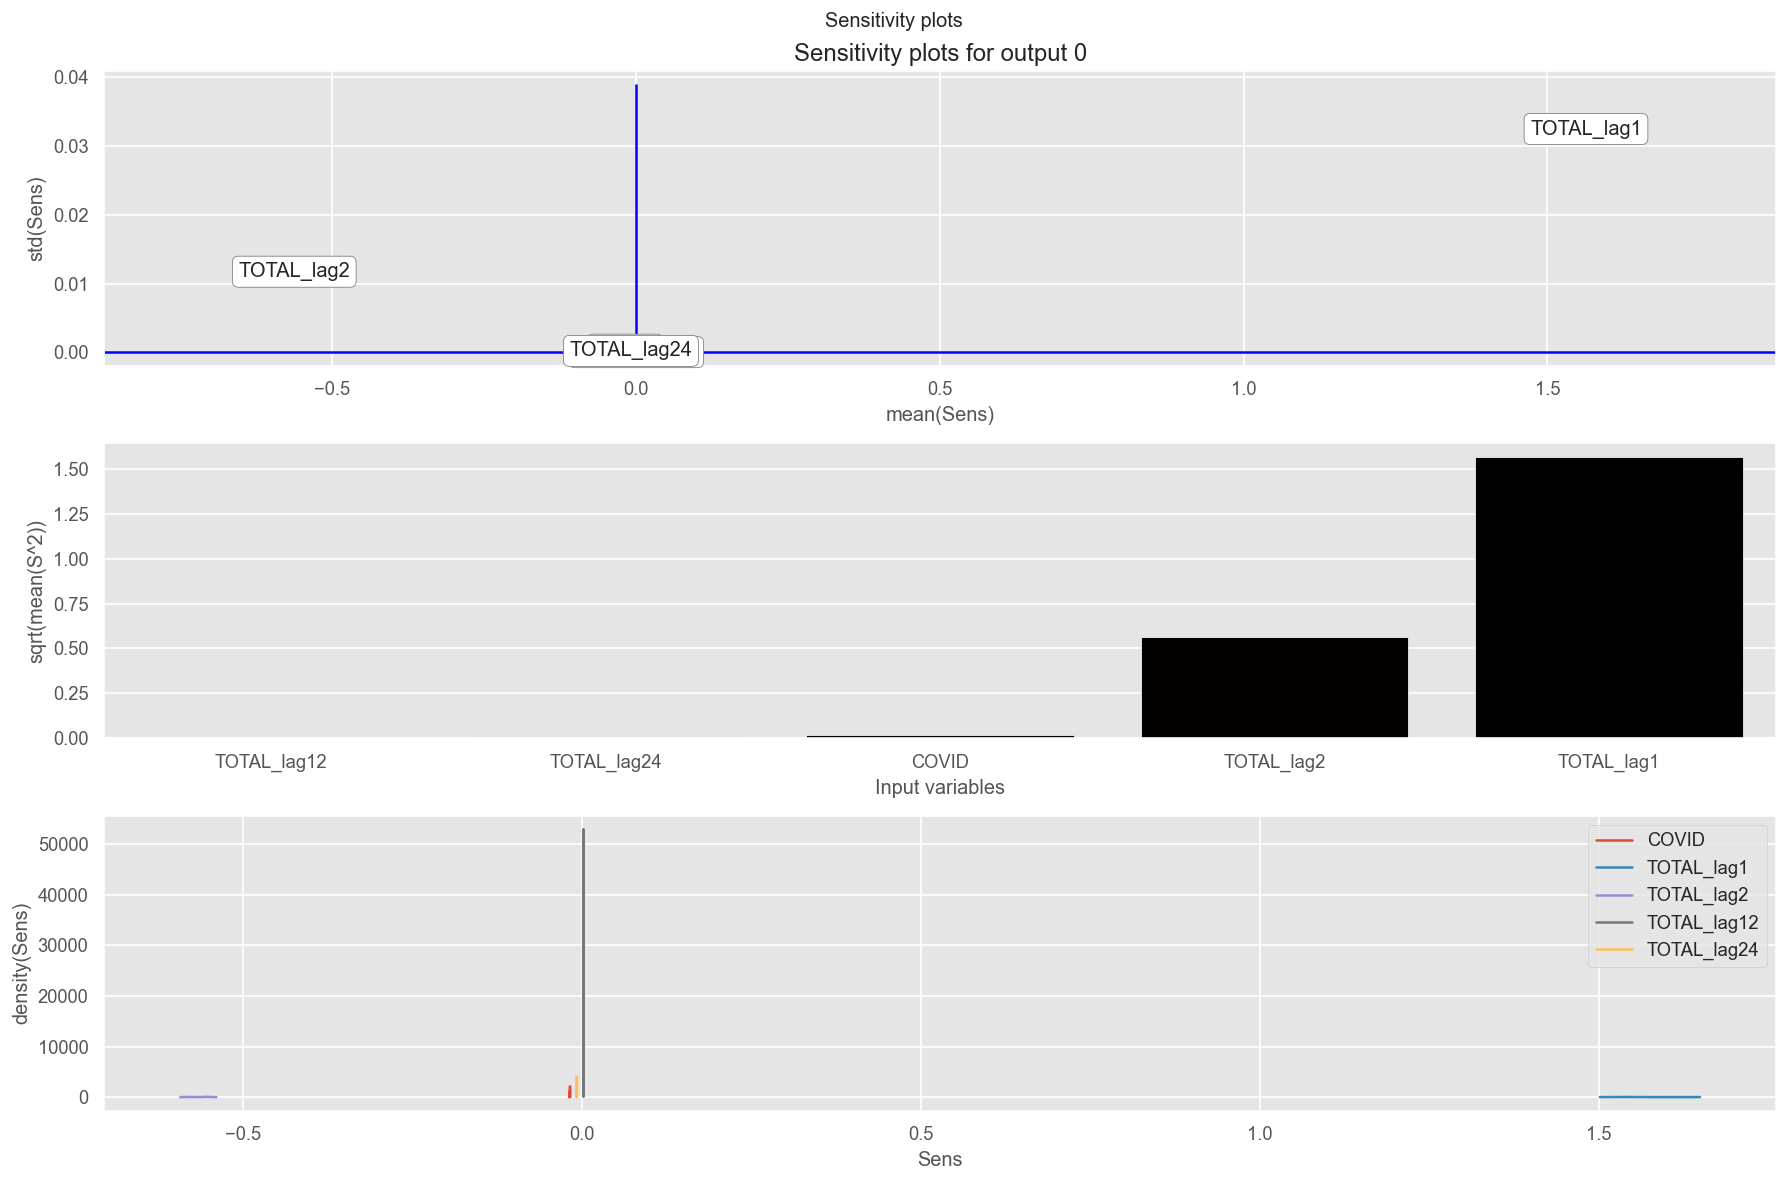

In [33]:
sensmlp.plot()

In [34]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval["MLP_pred"] = MLP_fit.predict(X_train)
### Scale test using preprocess in training
dfTS_eval["MLP_pred"] = MLP_fit.predict(X_test)

# Training and test MAE - Mean Absolute error
print("Training MAE:", mean_absolute_error(dfTR_eval["TOTAL"], dfTR_eval["MLP_pred"]))
print("Test MAE:", mean_absolute_error(dfTS_eval["TOTAL"], dfTS_eval["MLP_pred"]))
# Training and test RMSE - Root Mean Square Error
print(
    "Training RMSE:",
    math.sqrt(mean_squared_error(dfTR_eval["TOTAL"], dfTR_eval["MLP_pred"])),
)
print(
    "Test RMSE:",
    math.sqrt(mean_squared_error(dfTS_eval["TOTAL"], dfTS_eval["MLP_pred"])),
)
# Training and test r^2
print("Training R2:", r2_score(dfTR_eval["TOTAL"], dfTR_eval["MLP_pred"]))
print("Test R2:", r2_score(dfTS_eval["TOTAL"], dfTS_eval["MLP_pred"]))

# MAPE
print(
    "Training MAPE:",
    mean_absolute_percentage_error(dfTR_eval["TOTAL"], dfTR_eval["MLP_pred"])*100,
)

mape_mlp = mean_absolute_percentage_error(dfTS_eval["TOTAL"], dfTS_eval["MLP_pred"])*100
print(f"Test MAPE: {mape_mlp:.2f}")

Training MAE: 0.046625607343826744
Test MAE: 0.037438026786184186
Training RMSE: 0.05990525835319049
Test RMSE: 0.04448984984261445
Training R2: 0.9961857195940884
Test R2: 0.9477622598705177
Training MAPE: 1.413098265389416
Test MAPE: 1.30


In [35]:
dfTS_eval.iloc[0]

COVID          0.000000
TOTAL_lag1     3.333915
TOTAL_lag2     3.416498
TOTAL_lag12    3.776485
TOTAL_lag24    3.079711
TOTAL          3.257802
MLP_pred       3.301851
Name: 2021-09-01 00:00:00, dtype: float64

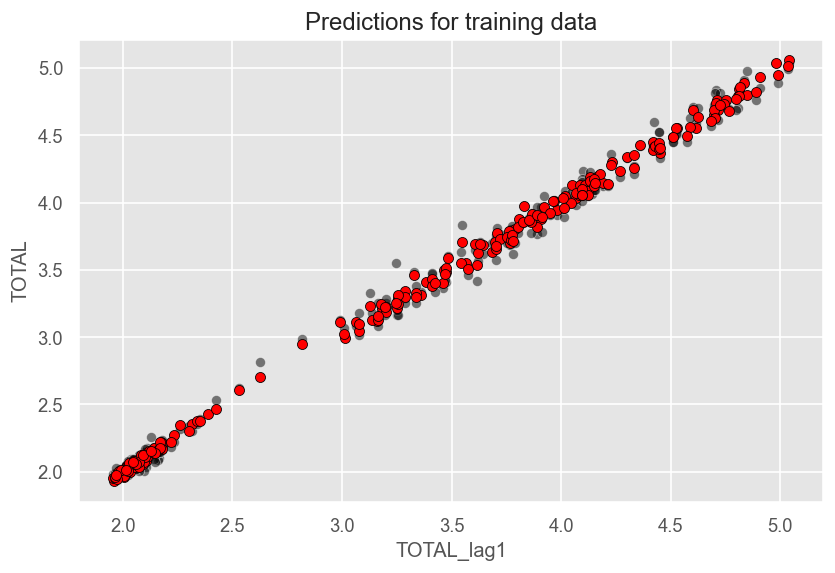

In [36]:
### Plot predictions of the model
sns.scatterplot(x="TOTAL_lag1", y="TOTAL", data=dfTR_eval, color="black", alpha=0.5)
sns.scatterplot(
    x="TOTAL_lag1", y="MLP_pred", data=dfTR_eval, color="red", edgecolor="black"
).set_title("Predictions for training data")
plt.show()

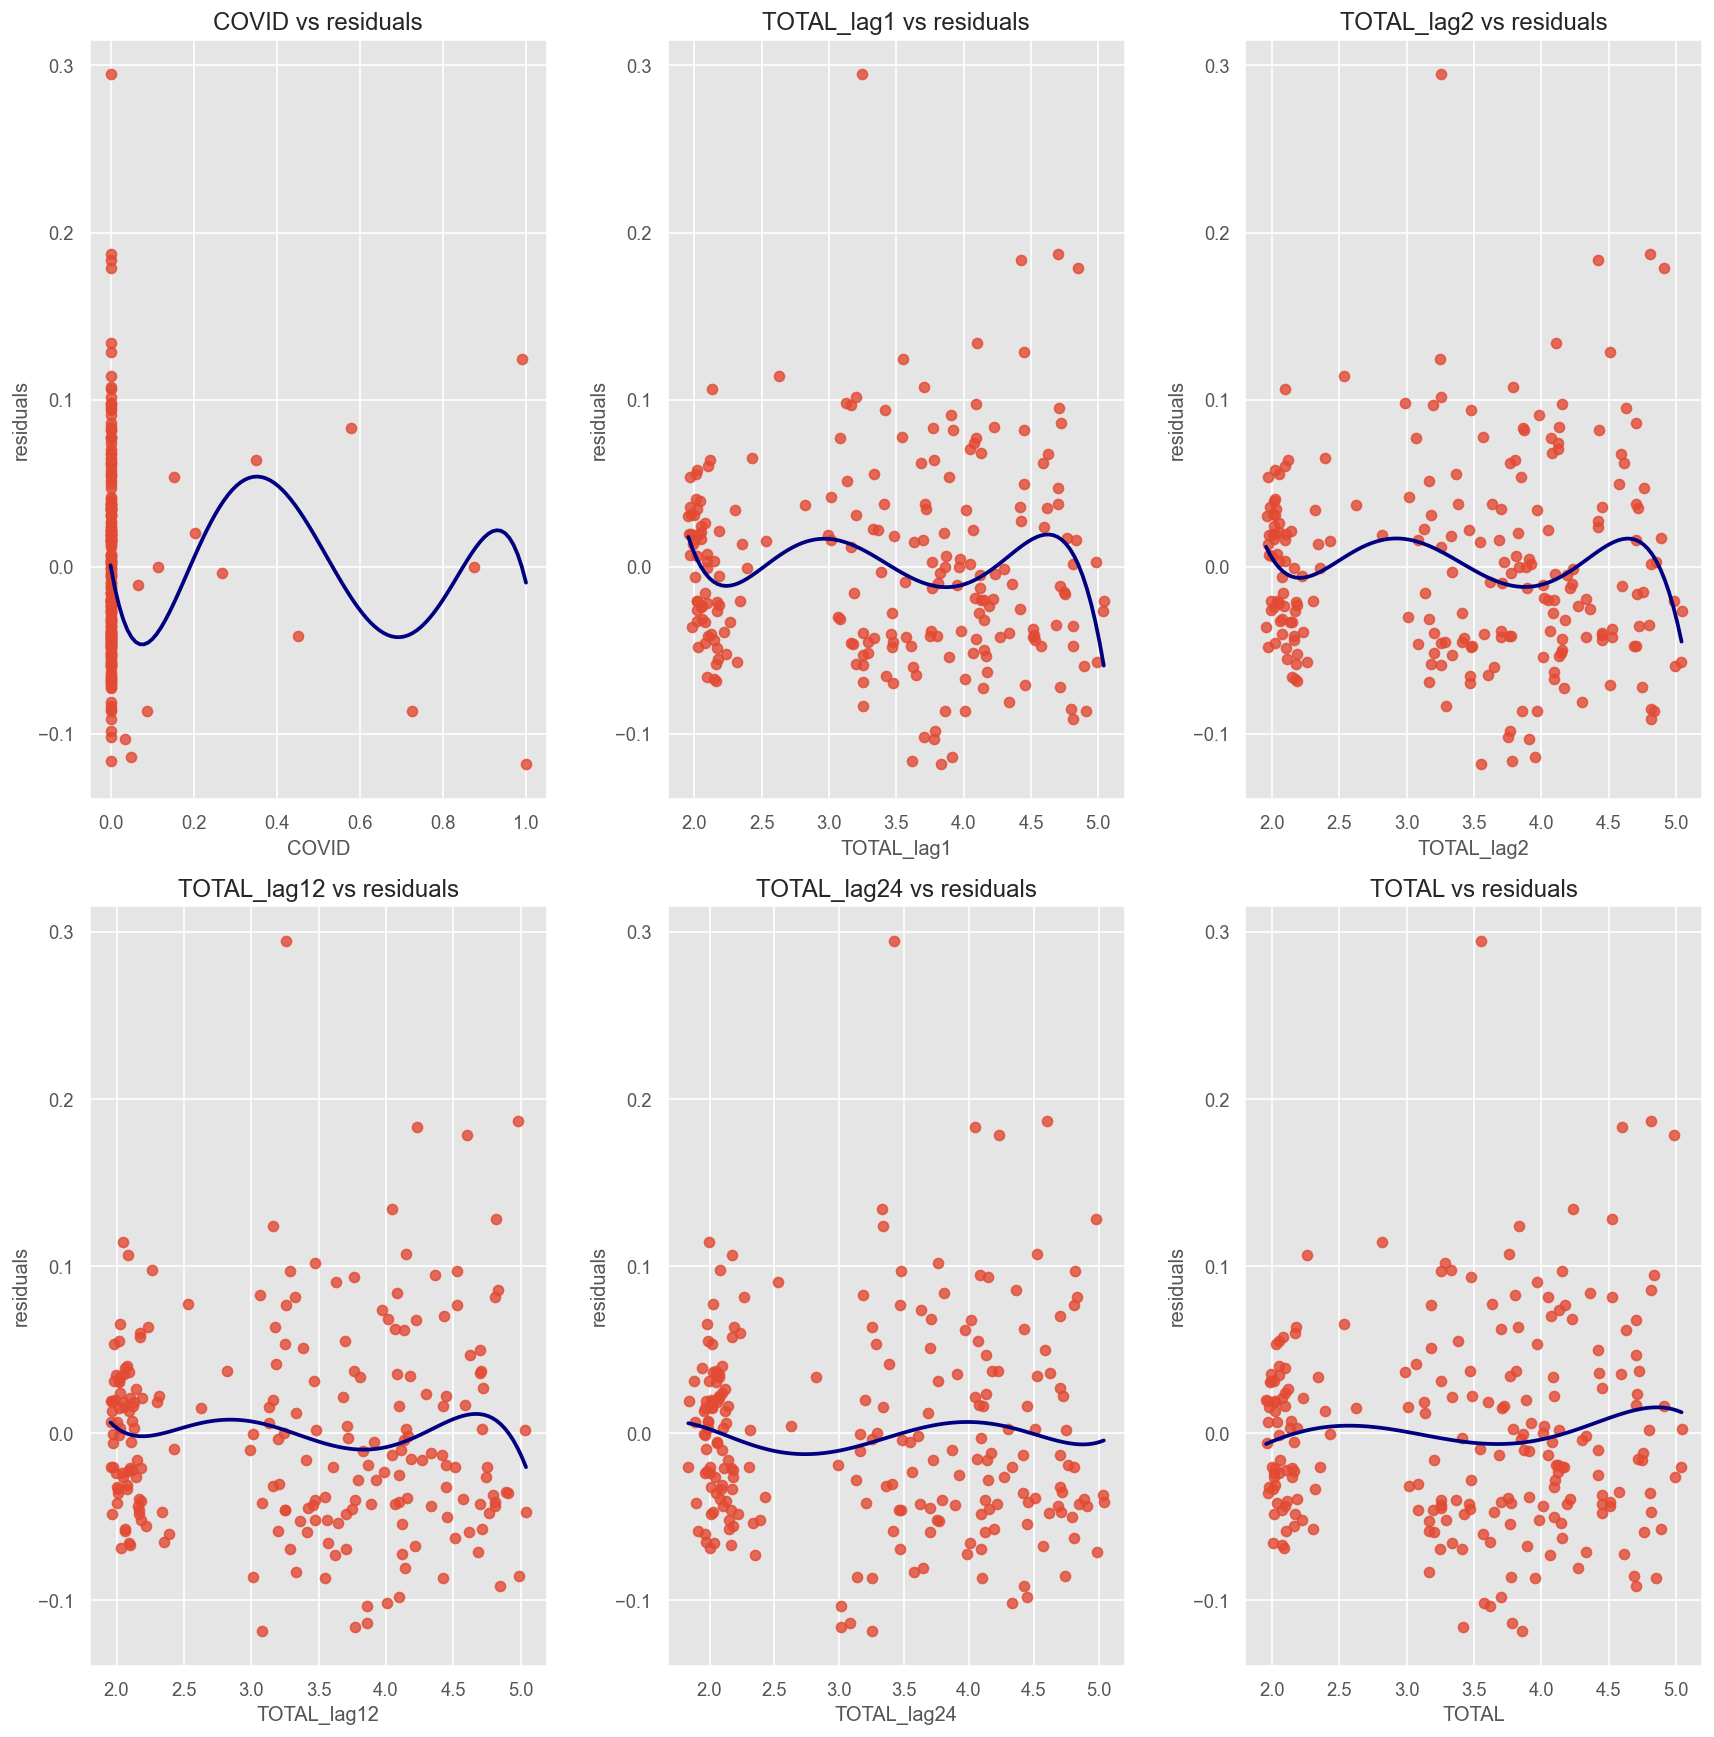

In [37]:
# Analysis of residuals
plotModelDiagnosis(dfTR_eval, "MLP_pred", "TOTAL", figsize=[15, 15])

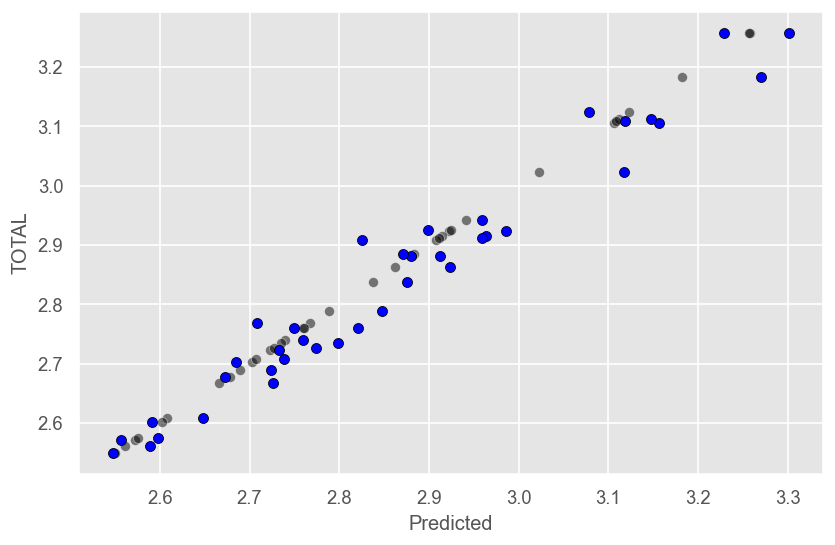

In [38]:
# Visualize prediction with respect to output
sns.scatterplot(data=dfTS_eval, x="TOTAL", y="TOTAL", color="black", alpha=0.5)
sns.scatterplot(
    data=dfTS_eval, x="MLP_pred", y="TOTAL", color="blue", edgecolor="black"
)
plt.xlabel("Predicted")
plt.show()

<Axes: xlabel='DATE', ylabel='TOTAL'>

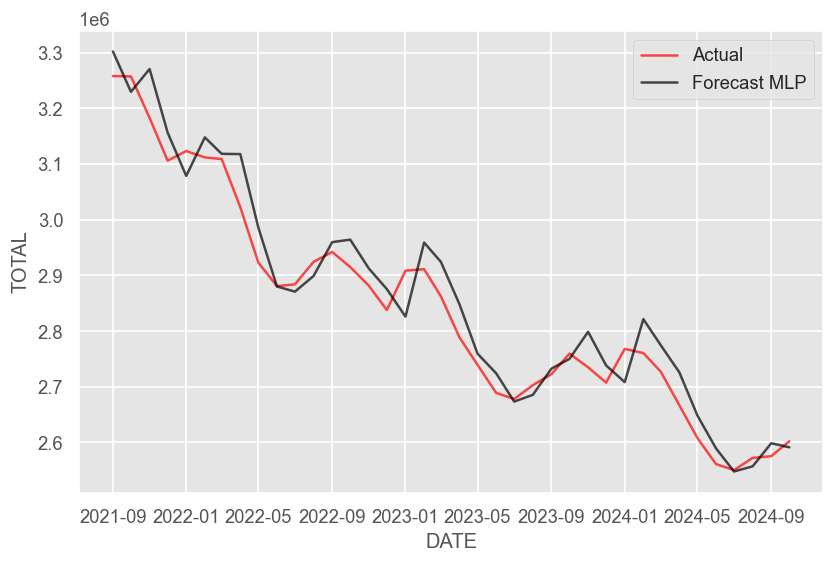

In [39]:
# plot real vs predicted
sns.lineplot(data=dfTS_eval*1e6, x=dfTS_eval.index, y="TOTAL", color="red", alpha=0.7, label='Actual')
sns.lineplot(data=dfTS_eval*1e6, x=dfTS_eval.index, y="MLP_pred", color="black", alpha=0.7, label='Forecast MLP')

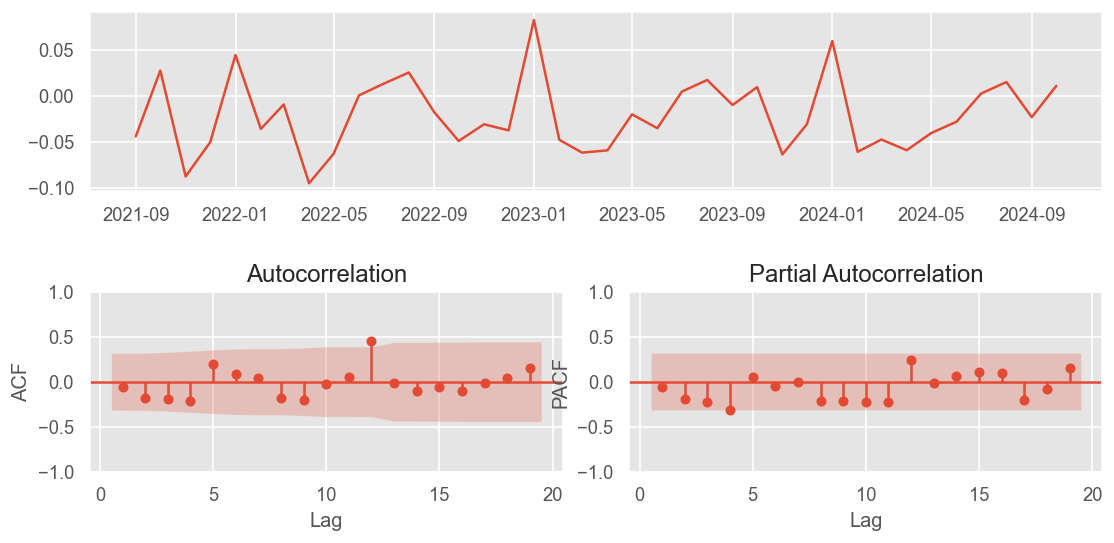

In [40]:
# Check correlation of residuals of TEST data
lags = min(19, len(dfTS_eval["TOTAL"] - dfTS_eval["MLP_pred"]) - 1)
ts_display(dfTS_eval["TOTAL"] - dfTS_eval["MLP_pred"], lags=lags)

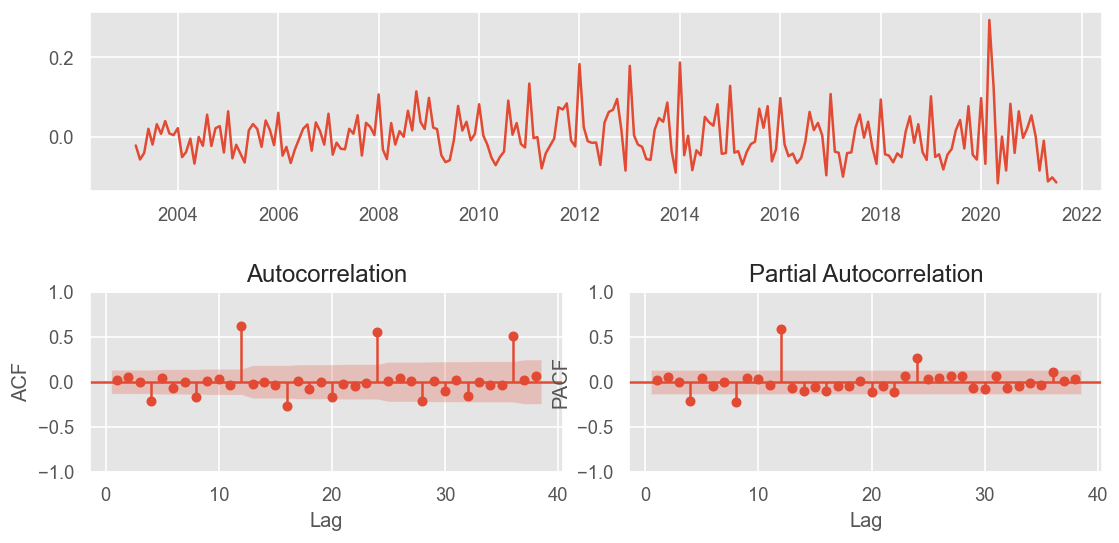

In [41]:
# Check correlation of residuals of TRAIN data
lags = min(19, len(dfTR_eval["TOTAL"] - dfTR_eval["MLP_pred"]) - 1)
ts_display(dfTR_eval["TOTAL"] - dfTR_eval["MLP_pred"], lags=lags * 2)

#### Residuals SARIMA Model

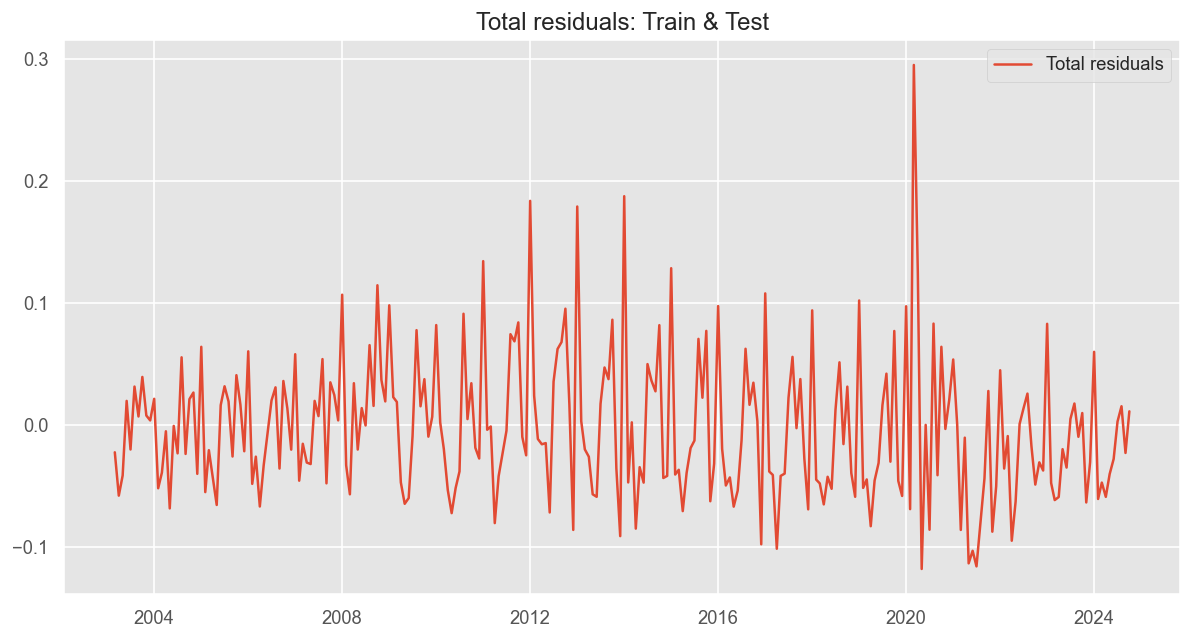

In [42]:
residuals_train = dfTR_eval["TOTAL"] - dfTR_eval["MLP_pred"]  # Residuals train
residuals_test = dfTS_eval["TOTAL"] - dfTS_eval["MLP_pred"]  # Residuals test

residuals_full = pd.concat([residuals_train, residuals_test]) # Total residuals

plt.figure(figsize=(12, 6))
plt.plot(residuals_full, label="Total residuals")
#plt.axhline(0, color='red', linestyle='--', label="Media")
plt.title("Total residuals: Train & Test")
plt.legend()
plt.show()

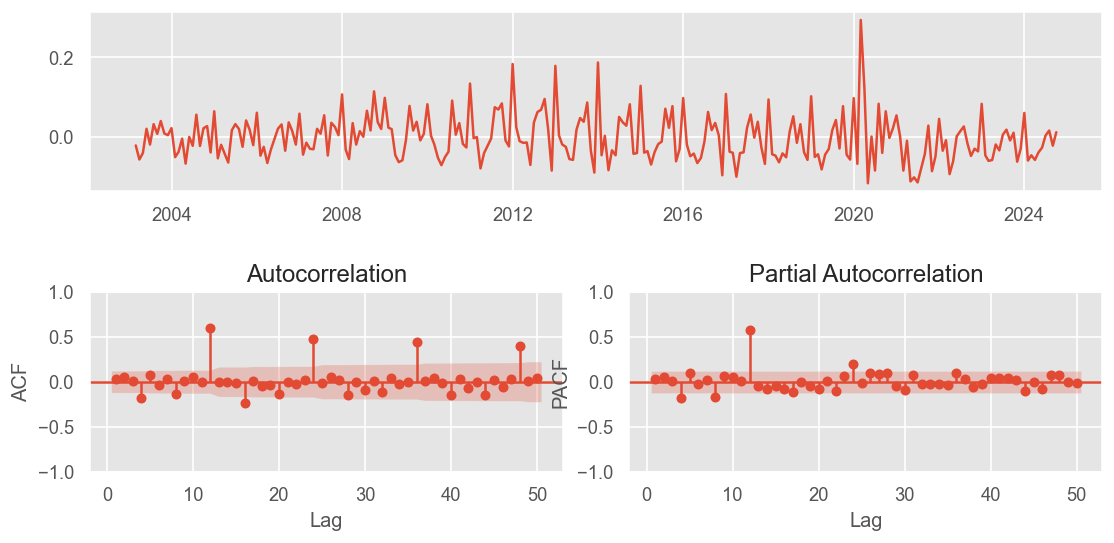

In [43]:
ts_display(residuals_full, lags=50)

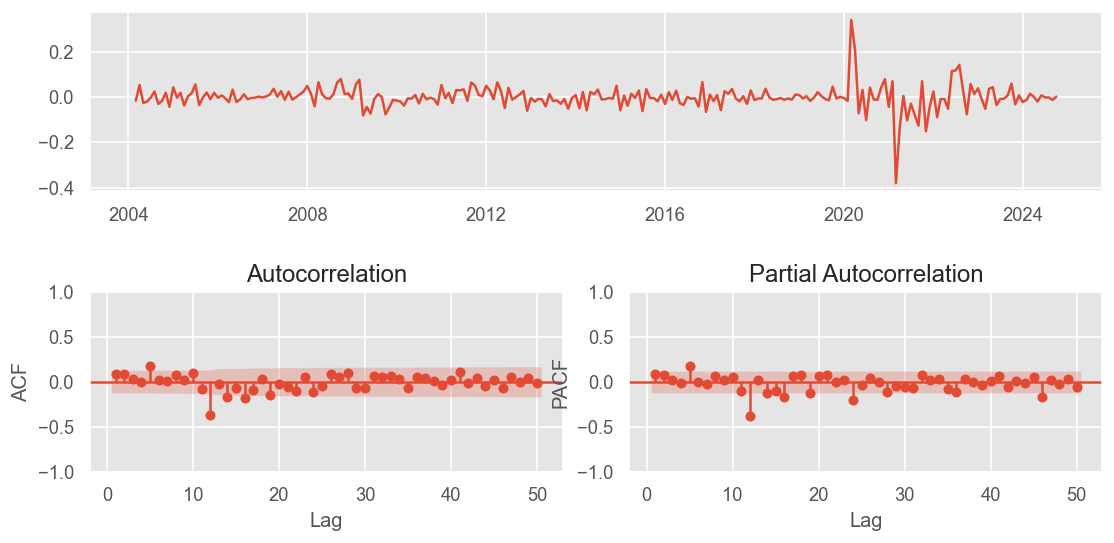

In [44]:
# Difference of the time series
d = 0  # y(t) - y(t-1) -> regular differencing
D = 1  # y(t) - y(t-s) -> seasonal differencing
S = 12  # Seasonality of 12 days

z = residuals_full  # for simplicity in the next steps

Bz = z
for diff in range(d):
    Bz = Bz.diff().dropna()  # drop first NA value
for seas_diff in range(D):
    Bz = Bz.diff(S).dropna()  # drop first NA values
ts_display(Bz, lags=50)


In [45]:
# Fit model with estimated order
residuals_full_fit_SARIMA = SARIMAX(
    residuals_full,
    # First, we observe the regular order
    order=(0, 0, 0),  # Regular components -> (p, d, q) -> p = 1, d = 2, q = 1
    # Second, we observe the seasonal order
    seasonal_order=(
        0,
        1,
        1,
        12,
    ),  # Seasonal components -> (P, D, Q, S) -> P = 1, D = 1, Q = 1, S = 12
    trend="n",  # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
).fit()

print(residuals_full_fit_SARIMA.summary())

/opt/miniconda3/envs/ML1/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/miniconda3/envs/ML1/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.56960D+00    |proj g|=  3.35200D+00

At iterate    5    f= -1.57824D+00    |proj g|=  1.66872D-01

At iterate   10    f= -1.58102D+00    |proj g|=  1.04213D+00

At iterate   15    f= -1.58180D+00    |proj g|=  2.71042D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     16     22      1     0     0   1.387D-04  -1.582D+00
  F =  -1.5817964334222825     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
        

Ljung-Box test of residuals:
      lb_stat  lb_pvalue
50  50.145483   0.467622


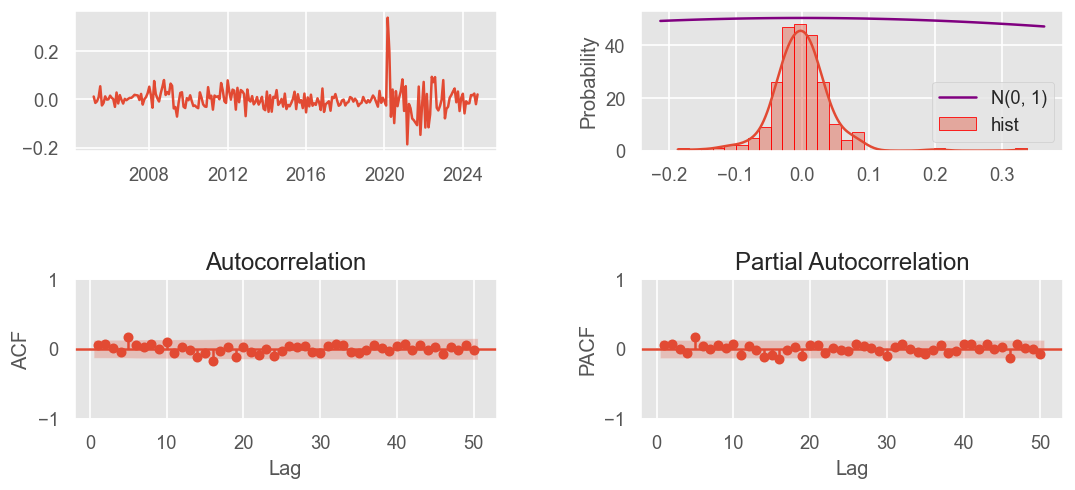

In [46]:
# Plot residual error
date_50 = df.index[50]  # We have chosen to see the residuals from the 50th month
check_residuals(pd.DataFrame(residuals_full_fit_SARIMA.resid.loc[date_50:]), lags=50)

<Figure size 960x600 with 0 Axes>

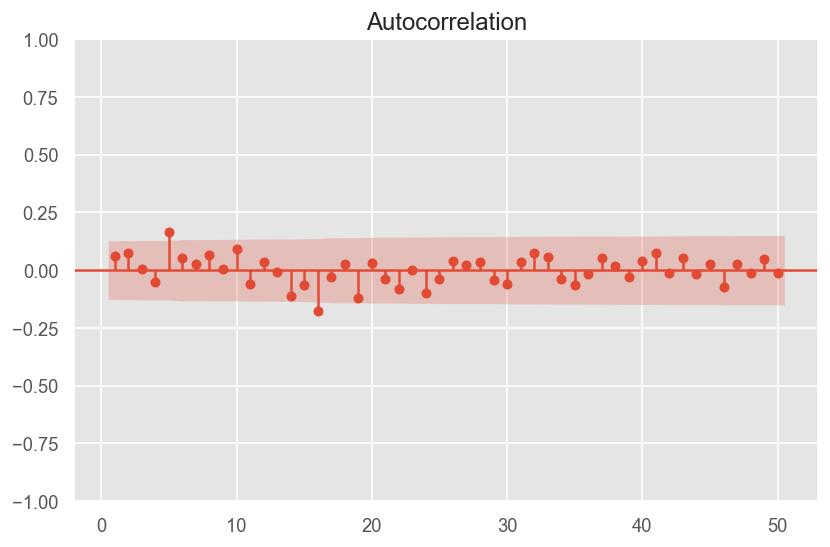

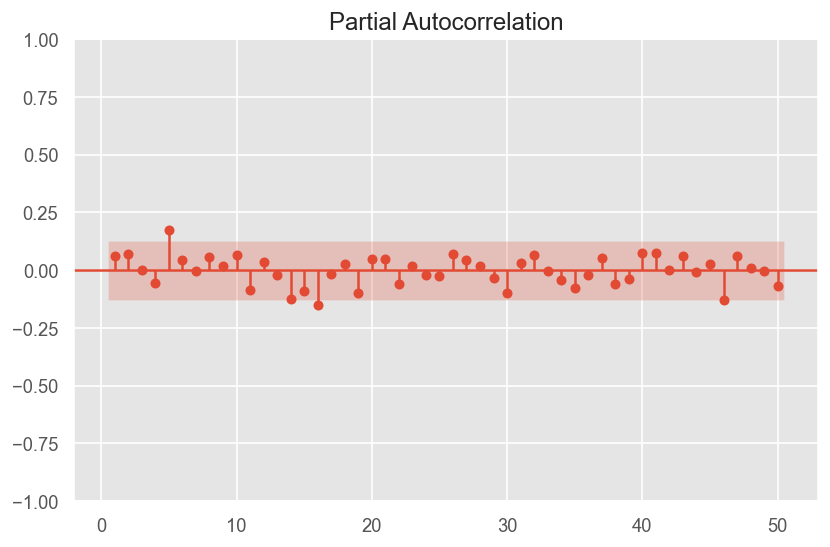

In [47]:
# Bigger plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure()
plot_acf(residuals_full_fit_SARIMA.resid.loc[date_50:], lags=50, zero=False)
plot_pacf(residuals_full_fit_SARIMA.resid.loc[date_50:], lags=50, zero=False);

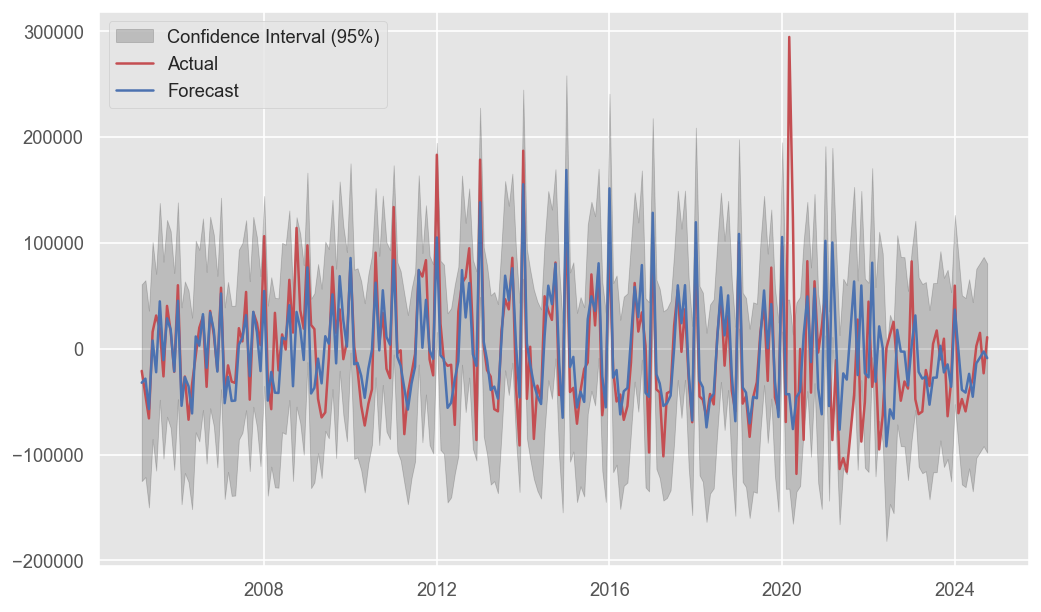

In [48]:
# Define start and end points using dates instead of numeric indices
start_date = df_ts.index[50]  # Date corresponding to the 50th point
horizon = 0
end_date = df_ts.index[-1] + pd.DateOffset(
    horizon
)  # Date corresponding to the last point + horizon

# Obtain forecasts for in-sample and out-of-sample
pred_SARIMA_res = residuals_full_fit_SARIMA.get_prediction(start=start_date, end=end_date, dynamic=False)
yhat_SARIMA_res = pred_SARIMA_res.predicted_mean*1e6
yhat_conf_int_SARIMA_res = pred_SARIMA_res.conf_int(alpha=0.05)*1e6


# Plot forecasts with confidence intervals
plt.figure(figsize=(10, 6))
plt.fill_between(
    yhat_conf_int_SARIMA_res.index,
    yhat_conf_int_SARIMA_res.iloc[:, 0],
    yhat_conf_int_SARIMA_res.iloc[:, 1],
    color="k",
    alpha=0.2,
    label="Confidence Interval (95%)",
)
plt.plot(residuals_full.loc[start_date:]*1e6, label="Actual", c="r")
plt.plot(yhat_SARIMA_res, label="Forecast", color="b")
plt.legend()
plt.show()

/opt/miniconda3/envs/ML1/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/miniconda3/envs/ML1/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


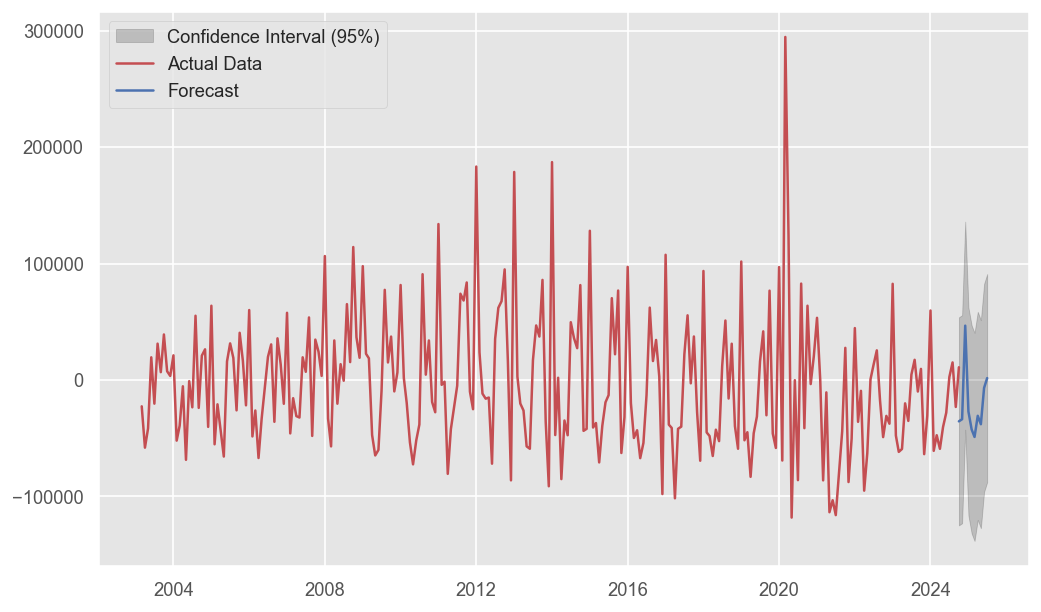

In [49]:
# Define horizon for out-of-sample forecast
horizon = 10
end_date = df_ts.index[-1] + pd.DateOffset(
    horizon
)  # Date corresponding to the last point + horizon

# Obtain out-of-sample forecast using SARIMAX model
pred_SARIMA_res_hor = residuals_full_fit_SARIMA.get_forecast(steps=horizon, dynamic=False)
yhat_SARIMA_res_hor = pred_SARIMA_res_hor.predicted_mean*1e6
yhat_conf_int_SARIMA_res_hor = pred_SARIMA_res_hor.conf_int(alpha=0.05)*1e6

# Ajustar el índice de las predicciones para que sean continuas con el índice original
forecast_index = pd.date_range(
    start=residuals_full.index[-1],  # El primer día del siguiente mes
    periods=horizon,  # El número de periodos de predicción
    freq='MS'  # 'MS' significa "Month Start", que ajusta al primer día de cada mes
)

# Reasignar el índice corregido
yhat_SARIMA_res_hor.index = forecast_index
yhat_conf_int_SARIMA_res_hor.index = forecast_index

# Plot the forecast with confidence intervals
plt.figure(figsize=(10, 6))
plt.fill_between(
    yhat_conf_int_SARIMA_res_hor.index,
    yhat_conf_int_SARIMA_res_hor.iloc[:, 0],
    yhat_conf_int_SARIMA_res_hor.iloc[:, 1],
    color="k",
    alpha=0.2,
    label="Confidence Interval (95%)",
)

#print(residuals_full)
#print(yhat_SARIMA_res_hor)

# Plot the actual data until the forecast starts, and then the forecasted values
plt.plot(residuals_full*1e6, label="Actual Data", c="r")
plt.plot(yhat_SARIMA_res_hor.index, yhat_SARIMA_res_hor, label="Forecast", color="b")

plt.legend()
plt.show()

In [50]:
print(yhat_SARIMA_res_hor)

2024-10-01   -35569.628666
2024-11-01   -33728.584586
2024-12-01    46644.438384
2025-01-01   -27108.963491
2025-02-01   -42527.257945
2025-03-01   -48964.329728
2025-04-01   -30821.612541
2025-05-01   -38032.819734
2025-06-01    -6851.567342
2025-07-01     1608.633938
Freq: MS, Name: predicted_mean, dtype: float64


In [51]:
error_prediccion_NOVIEMBRE=yhat_SARIMA_res_hor[1]
print('error_prediccion_NOVIEMBRE:', error_prediccion_NOVIEMBRE)

error_prediccion_NOVIEMBRE: -33728.58458566132


/var/folders/bf/btmmkbn94nl5_mb9xq58ntzm0000gn/T/ipykernel_1436/3941723423.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  error_prediccion_NOVIEMBRE=yhat_SARIMA_res_hor[1]


## **e) Obtain the best forecast for the unemployment rate of November 2024**

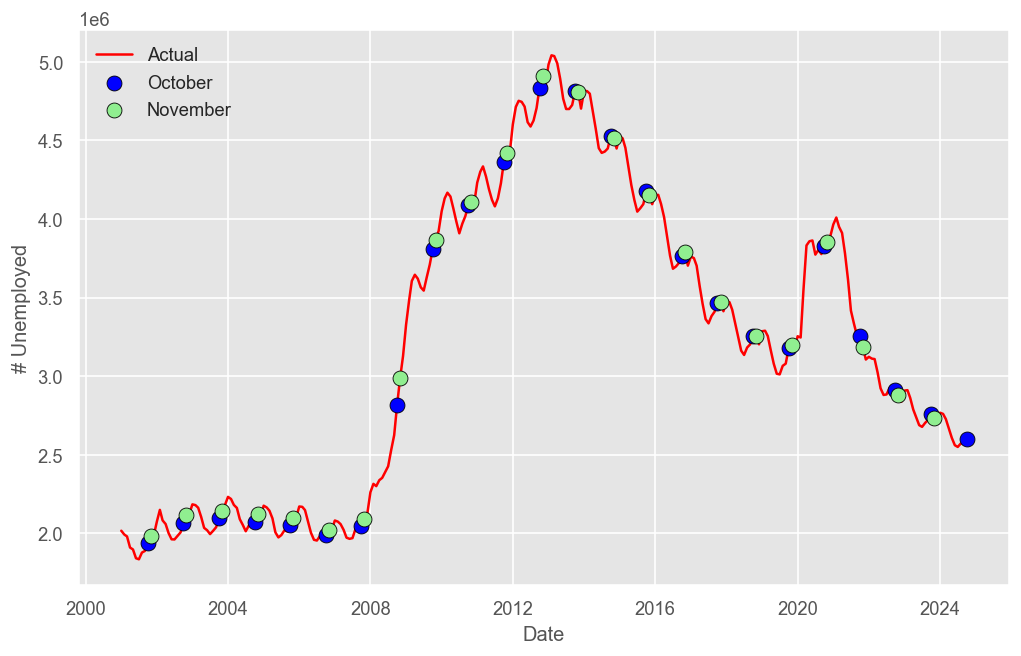

In [76]:
# Plotear los datos
fig, ax = plt.subplots(figsize=(10, 6))

# Dibuja la línea con un zorder bajo para que los puntos estén encima
ax.plot(df.index, df["TOTAL"], label="Actual", color='red', zorder=1)

# Resaltar octubre y noviembre con un zorder alto
for idx, row in df.iterrows():
    if idx.month == 10:  # Octubre
        ax.scatter(idx, row["TOTAL"], color="blue", edgecolor="black", s=80, label="October" if idx.year == 2001 else "", zorder=2)
    elif idx.month == 11:  # Noviembre
        ax.scatter(idx, row["TOTAL"], color="lightgreen", edgecolor="black", s=80, label="November" if idx.year == 2001 else "", zorder=2)

# Personalización
ax.set(
    #title="Unemployment data in Spain from January 2001 to October 2024",
    xlabel="Date",
    ylabel="# Unemployed",
)
ax.legend(loc="upper left", frameon=False)
plt.show()


### **SARIMA's forecast**

In [53]:
### SARIMAX as Best Model

# Display model metrics and configuration
print("SARIMAX Model Configuration and Metrics:")
print(f"- ARIMA Order: {sarima_fit.model.order}")
print(f"- Seasonal Order: {sarima_fit.model.seasonal_order}")
print("- Intervention Variable: COVID (χ² distribution)")
print(f"- AIC: {sarima_fit.aic:.2f}")
print(f"- BIC: {sarima_fit.bic:.2f}")
print(f"- Log-Likelihood: {sarima_fit.llf:.2f}")
print(f"- MAE: {mae_sarima:.2f}")
print(f"- RMSE: {rmse_sarima:.2f}")
print(f"- MAPE: {mape_sarima:.6f}")
print(f"- R2: {r2_sarima:.4f}")

SARIMAX Model Configuration and Metrics:
- ARIMA Order: (1, 1, 0)
- Seasonal Order: (0, 1, 1, 12)
- Intervention Variable: COVID (χ² distribution)
- AIC: -952.97
- BIC: -942.14
- Log-Likelihood: 479.48
- MAE: 38033.25
- RMSE: 62613.83
- MAPE: 1.149218
- R2: 0.9798


Unemployment in October 2024: 2602054
Unemployment Prediction for November 2024 (SARIMA): 2583121
Difference between November 2024 (SARIMA) and October 2024: -18933
Percentage difference between November 2024 (SARIMA) and October 2024: -0.7276174898753063%


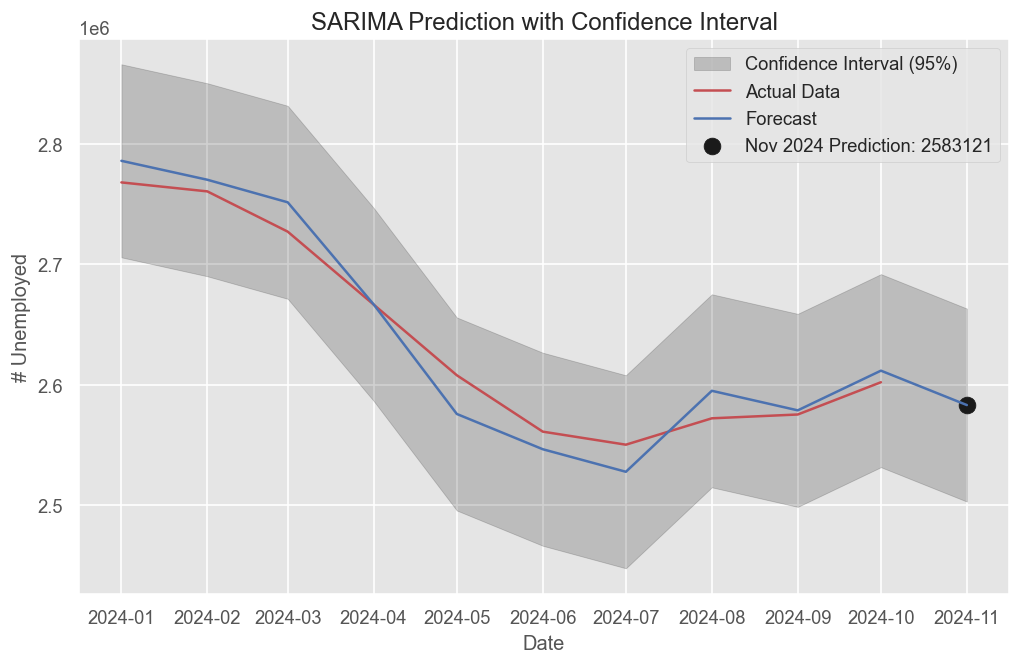

In [54]:
# Define start and end points using dates instead of numeric indices
start_date = df_ts.index[
    276
]  # Start of predictions (adjust index according to dataset)
horizon = 31
end_date = df_ts.index[-1] + pd.DateOffset(horizon)  # Last point date plus horizon

# Get predictions for in-sample and out-of-sample
pred_SARIMA = sarima_fit.get_prediction(
    start=start_date, end=end_date, dynamic=False
)
yhat_SARIMA = pred_SARIMA.predicted_mean*1e6
yhat_conf_int_SARIMA = pred_SARIMA.conf_int(alpha=0.05)*1e6  # 95% Confidence Interval

# Plot predictions with confidence intervals
plt.figure(figsize=(10, 6))
plt.fill_between(
    yhat_conf_int_SARIMA.index,
    yhat_conf_int_SARIMA.iloc[:, 0],
    yhat_conf_int_SARIMA.iloc[:, 1],
    color="k",
    alpha=0.2,
    label="Confidence Interval (95%)",
)
plt.plot(
    df_ts["TOTAL"].loc[start_date:]*1e6, label="Actual Data", color="r"
)  # Actual values
plt.plot(yhat_SARIMA, label="Forecast", color="b")  # Predictions

# Get unemployment in October 2024
unemployment_october = int(
    df_ts["TOTAL"].loc['2024-10-01']*1e6
)  # Last real data point (October 2024)
print(f"Unemployment in October 2024: {unemployment_october}")

# Get predictions for November 2024
pred_SARIMA_november = sarima_fit.get_forecast(steps=1, exog=X[0:1])
november_2024_pred = int(pred_SARIMA_november.predicted_mean.iloc[0]*1e6)
print(f"Unemployment Prediction for November 2024 (SARIMA): {november_2024_pred}")

# Calculate the difference between November prediction and October unemployment
diff = november_2024_pred - unemployment_october
print(f"Difference between November 2024 (SARIMA) and October 2024: {diff}")

# Calculate percentage difference
percentage_diff = (diff / unemployment_october) * 100
print(
    f"Percentage difference between November 2024 (SARIMA) and October 2024: {percentage_diff}%"
)

# Add point for November 2024
november_2024_date = end_date  # Use calculated date for the end
plt.scatter(
    november_2024_date,
    november_2024_pred,
    color="k",
    s=100,
    label=f"Nov 2024 Prediction: {november_2024_pred}",
)

plt.title("SARIMA Prediction with Confidence Interval")
plt.xlabel("Date")
plt.ylabel("# Unemployed")
plt.legend()
plt.show()

### **SARIMAX's forecast**

In [55]:
### SARIMAX as Best Model

# Display model metrics and configuration
print("SARIMAX Model Configuration and Metrics:")
print(f"- ARIMA Order: {res_sarimax.model.order}")
print(f"- Seasonal Order: {res_sarimax.model.seasonal_order}")
print("- Intervention Variable: COVID (χ² distribution)")
print(f"- AIC: {res_sarimax.aic:.2f}")
print(f"- BIC: {res_sarimax.bic:.2f}")
print(f"- Log-Likelihood: {res_sarimax.llf:.2f}")
print(f"- MAE: {mae_sarimax:.2f}")
print(f"- RMSE: {rmse_sarimax:.2f}")
print(f"- MAPE: {mape_sarimax:.6f}")
print(f"- R2: {r2_sarimax:.4f}")

SARIMAX Model Configuration and Metrics:
- ARIMA Order: (1, 1, 0)
- Seasonal Order: (0, 1, 1, 12)
- Intervention Variable: COVID (χ² distribution)
- AIC: -974.52
- BIC: -960.08
- Log-Likelihood: 491.26
- MAE: 34851.63
- RMSE: 58195.51
- MAPE: 1.059804
- R2: 0.9826


In [56]:
X = df_ts["COVID"]
y = df_ts["TOTAL"]

Unemployment in October 2024: 2602054.0
Unemployment Prediction for November 2024 (SARIMAX): 2582946
Difference between November 2024 (SARIMAX) and October 2024: -19108.0
Percentage difference between November 2024 (SARIMAX) and October 2024: -0.7343429459957403%


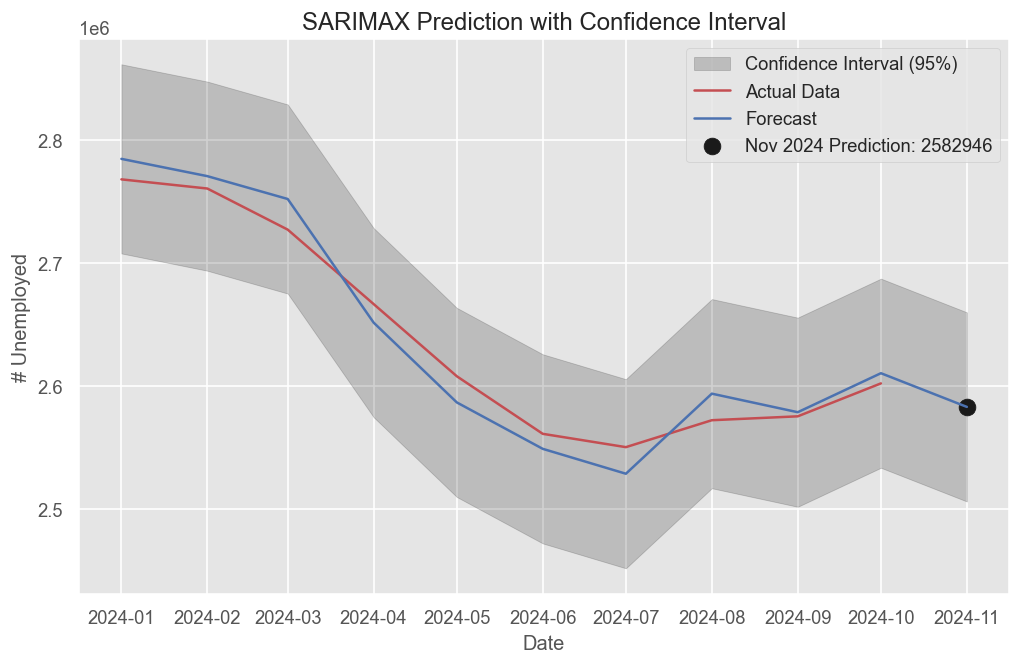

In [57]:
# Define start and end points using dates instead of numeric indices
start_date = df_ts.index[
    276
]  # Start of predictions (adjust index according to dataset)
horizon = 31
end_date = df_ts.index[-1] + pd.DateOffset(horizon)  # Last point date plus horizon

# Get predictions for in-sample and out-of-sample
pred_SARIMAX = res_sarimax.get_prediction(
    start=start_date, end=end_date, exog=X[0:1], dynamic=False
)
yhat_SARIMAX = pred_SARIMAX.predicted_mean*1e6
yhat_conf_int_SARIMAX = pred_SARIMAX.conf_int(alpha=0.05)*1e6  # 95% Confidence Interval

# Plot predictions with confidence intervals
plt.figure(figsize=(10, 6))
plt.fill_between(
    yhat_conf_int_SARIMAX.index,
    yhat_conf_int_SARIMAX.iloc[:, 0],
    yhat_conf_int_SARIMAX.iloc[:, 1],
    color="k",
    alpha=0.2,
    label="Confidence Interval (95%)",
)
plt.plot(
    df_ts["TOTAL"].loc[start_date:]*1e6, label="Actual Data", color="r"
)  # Actual values
plt.plot(yhat_SARIMAX, label="Forecast", color="b")  # Predictions

# Get unemployment in October 2024
unemployment_october = float(
    df_ts["TOTAL"].loc['2024-10-01']*1e6
)  # Last real data point (October 2024)
print(f"Unemployment in October 2024: {unemployment_october}")

# Get predictions for November 2024
pred_SARIMAX_november = res_sarimax.get_forecast(steps=1, exog=X[0:1])
november_2024_pred = int(pred_SARIMAX_november.predicted_mean.iloc[0]*1e6)
print(f"Unemployment Prediction for November 2024 (SARIMAX): {november_2024_pred}")

# Calculate the difference between November prediction and October unemployment
diff = november_2024_pred - unemployment_october
print(f"Difference between November 2024 (SARIMAX) and October 2024: {diff}")

# Calculate percentage difference
percentage_diff = (diff / unemployment_october) * 100
print(
    f"Percentage difference between November 2024 (SARIMAX) and October 2024: {percentage_diff}%"
)

# Add point for November 2024
november_2024_date = end_date  # Use calculated date for the end
plt.scatter(
    november_2024_date,
    november_2024_pred,
    color="k",
    s=100,
    label=f"Nov 2024 Prediction: {november_2024_pred}",
)

plt.title("SARIMAX Prediction with Confidence Interval")
plt.xlabel("Date")
plt.ylabel("# Unemployed")
plt.legend()
plt.show()

### **NARX's forecast (with residuals modeled as SARIMA)**

In [58]:
print(len(dfTR_eval["MLP_pred"]))
print(len(dfTS_eval["MLP_pred"]))
print(len(yhat_SARIMA_res))

221
38
235


In [59]:
dfTR_eval["MLP_pred"]

DATE
2003-03-01    2.186164
2003-04-01    2.162662
2003-05-01    2.077270
2003-06-01    2.000908
2003-07-01    2.016339
                ...   
2021-03-01    4.035936
2021-04-01    3.921306
2021-05-01    3.894919
2021-06-01    3.717722
2021-07-01    3.532654
Name: MLP_pred, Length: 221, dtype: float64

In [60]:
display(dfTS_eval[["MLP_pred"]])

MLP_pred
DATE                
2021-09-01  3.301851
2021-10-01  3.229484
2021-11-01  3.270419
2021-12-01  3.156376
2022-01-01  3.078500
2022-02-01  3.147665
2022-03-01  3.118117
2022-04-01  3.117650
2022-05-01  2.985934
2022-06-01  2.880038
2022-07-01  2.870620
2022-08-01  2.898809
2022-09-01  2.959561
2022-10-01  2.964010
2022-11-01  2.912277
2022-12-01  2.875245
2023-01-01  2.825777
2023-02-01  2.958804
2023-03-01  2.924072
2023-04-01  2.847684
2023-05-01  2.759217
2023-06-01  2.724031
2023-07-01  2.673217
2023-08-01  2.685393
2023-09-01  2.732428
2023-10-01  2.749899
2023-11-01  2.798602
2023-12-01  2.738196
2024-01-01  2.708192
2024-02-01  2.821325
2024-03-01  2.774516
2024-04-01  2.725677
2024-05-01  2.648319
2024-06-01  2.589179
2024-07-01  2.547728
2024-08-01  2.557063
2024-09-01  2.598484
2024-10-01  2.591139

In [61]:
# Renombrar la columna si es necesario
dfTR_eval.reset_index(inplace=True)
dfTS_eval.reset_index(inplace=True)

# Ahora 'DATE' es una columna regular en ambos DataFrames
print(dfTR_eval.head())
print(dfTS_eval.head())

        DATE  COVID  TOTAL_lag1  TOTAL_lag2  TOTAL_lag12  TOTAL_lag24  \
0 2003-03-01    0.0    2.180216    2.185156     2.083103     1.981006   
1 2003-04-01    0.0    2.163499    2.180216     2.060069     1.910453   
2 2003-05-01    0.0    2.104474    2.163499     2.002923     1.898285   
3 2003-06-01    0.0    2.035601    2.104474     1.962963     1.842556   
4 2003-07-01    0.0    2.020367    2.035601     1.961852     1.835738   

      TOTAL  MLP_pred  residuals  
0  2.163499  2.186164  -0.022665  
1  2.104474  2.162662  -0.058188  
2  2.035601  2.077270  -0.041669  
3  2.020367  2.000908   0.019459  
4  1.995964  2.016339  -0.020375  
        DATE  COVID  TOTAL_lag1  TOTAL_lag2  TOTAL_lag12  TOTAL_lag24  \
0 2021-09-01    0.0    3.333915    3.416498     3.776485     3.079711   
1 2021-10-01    0.0    3.257802    3.333915     3.826043     3.177659   
2 2021-11-01    0.0    3.257068    3.257802     3.851312     3.198184   
3 2021-12-01    0.0    3.182687    3.257068     3.888137   

In [62]:
display(dfTR_eval[["DATE","MLP_pred"]])

DATE  MLP_pred
0   2003-03-01  2.186164
1   2003-04-01  2.162662
2   2003-05-01  2.077270
3   2003-06-01  2.000908
4   2003-07-01  2.016339
..         ...       ...
216 2021-03-01  4.035936
217 2021-04-01  3.921306
218 2021-05-01  3.894919
219 2021-06-01  3.717722
220 2021-07-01  3.532654

[221 rows x 2 columns]

In [63]:
display(dfTS_eval[["DATE","MLP_pred"]])

DATE  MLP_pred
0  2021-09-01  3.301851
1  2021-10-01  3.229484
2  2021-11-01  3.270419
3  2021-12-01  3.156376
4  2022-01-01  3.078500
5  2022-02-01  3.147665
6  2022-03-01  3.118117
7  2022-04-01  3.117650
8  2022-05-01  2.985934
9  2022-06-01  2.880038
10 2022-07-01  2.870620
11 2022-08-01  2.898809
12 2022-09-01  2.959561
13 2022-10-01  2.964010
14 2022-11-01  2.912277
15 2022-12-01  2.875245
16 2023-01-01  2.825777
17 2023-02-01  2.958804
18 2023-03-01  2.924072
19 2023-04-01  2.847684
20 2023-05-01  2.759217
21 2023-06-01  2.724031
22 2023-07-01  2.673217
23 2023-08-01  2.685393
24 2023-09-01  2.732428
25 2023-10-01  2.749899
26 2023-11-01  2.798602
27 2023-12-01  2.738196
28 2024-01-01  2.708192
29 2024-02-01  2.821325
30 2024-03-01  2.774516
31 2024-04-01  2.725677
32 2024-05-01  2.648319
33 2024-06-01  2.589179
34 2024-07-01  2.547728
35 2024-08-01  2.557063
36 2024-09-01  2.598484
37 2024-10-01  2.591139

In [64]:
# Concatenamos el train y el test
# Asegúrate de que las fechas en ambos DataFrames estén en formato datetime
dfTR_eval['DATE'] = pd.to_datetime(dfTR_eval['DATE'])
dfTS_eval['DATE'] = pd.to_datetime(dfTS_eval['DATE'])

# Concatenar ambos DataFrames (train y test) según la columna 'DATE'
df_combined = pd.concat([dfTR_eval, dfTS_eval], axis=0)
df_combined

DATE  COVID  TOTAL_lag1  TOTAL_lag2  TOTAL_lag12  TOTAL_lag24  \
0  2003-03-01    0.0    2.180216    2.185156     2.083103     1.981006   
1  2003-04-01    0.0    2.163499    2.180216     2.060069     1.910453   
2  2003-05-01    0.0    2.104474    2.163499     2.002923     1.898285   
3  2003-06-01    0.0    2.035601    2.104474     1.962963     1.842556   
4  2003-07-01    0.0    2.020367    2.035601     1.961852     1.835738   
..        ...    ...         ...         ...          ...          ...   
33 2024-06-01    0.0    2.607850    2.666500     2.688842     2.880582   
34 2024-07-01    0.0    2.561067    2.607850     2.677874     2.883812   
35 2024-08-01    0.0    2.550237    2.561067     2.702700     2.924240   
36 2024-09-01    0.0    2.572121    2.550237     2.722468     2.941919   
37 2024-10-01    0.0    2.575285    2.572121     2.759404     2.914892   

       TOTAL  MLP_pred  residuals  
0   2.163499  2.186164  -0.022665  
1   2.104474  2.162662  -0.058188  
2   2.035601  2.077270  -0.041669  
3   2.020367  2.000908   0.019459  
4   1.995964  2.016339  -0.020375  
..       ...       ...        ...  
33  2.561067  2.589179        NaN  
34  2.550237  2.547728        NaN  
35  2.572121  2.557063        NaN  
36  2.575285  2.598484        NaN  
37  2.602054  2.591139        NaN  

[259 rows x 9 columns]

In [65]:
print(len(dfTR_eval))
print(len(dfTS_eval))
print(len(df_combined))

221
38
259


In [66]:
yhat_SARIMA_res  # prediccion residuos

DATE
2005-03-01   -32118.530078
2005-04-01   -28243.722204
2005-05-01   -56980.198812
2005-06-01     7815.944850
2005-07-01   -22165.583430
                  ...     
2024-06-01   -45355.759447
2024-07-01   -13760.773813
2024-08-01    -8318.742264
2024-09-01    -2618.279340
2024-10-01    -8818.785676
Name: predicted_mean, Length: 235, dtype: float64

In [67]:
# Cogemos del combinado desde 2005-03-01
# Asegúrate de que la columna 'DATE' esté en formato de fecha (si no lo está, puedes convertirla)
df_combined['DATE'] = pd.to_datetime(df_combined['DATE'])

# Filtrar el DataFrame para que solo contenga datos a partir de la fecha '2005-03-01'
df_filtered = df_combined[df_combined['DATE'] >= '2005-03-01']
display(df_filtered)

DATE  COVID  TOTAL_lag1  TOTAL_lag2  TOTAL_lag12  TOTAL_lag24  \
24 2005-03-01    0.0    2.165420    2.176599     2.181546     2.163499   
25 2005-04-01    0.0    2.144835    2.165420     2.162406     2.104474   
26 2005-05-01    0.0    2.095945    2.144835     2.090702     2.035601   
27 2005-06-01    0.0    2.007393    2.095945     2.054113     2.020367   
28 2005-07-01    0.0    1.974860    2.007393     2.014218     1.995964   
..        ...    ...         ...         ...          ...          ...   
33 2024-06-01    0.0    2.607850    2.666500     2.688842     2.880582   
34 2024-07-01    0.0    2.561067    2.607850     2.677874     2.883812   
35 2024-08-01    0.0    2.550237    2.561067     2.702700     2.924240   
36 2024-09-01    0.0    2.572121    2.550237     2.722468     2.941919   
37 2024-10-01    0.0    2.575285    2.572121     2.759404     2.914892   

       TOTAL  MLP_pred  residuals  
24  2.144835  2.165771  -0.020936  
25  2.095945  2.139554  -0.043609  
26  2.007393  2.073219  -0.065826  
27  1.974860  1.958911   0.015949  
28  1.989417  1.957995   0.031422  
..       ...       ...        ...  
33  2.561067  2.589179        NaN  
34  2.550237  2.547728        NaN  
35  2.572121  2.557063        NaN  
36  2.575285  2.598484        NaN  
37  2.602054  2.591139        NaN  

[235 rows x 9 columns]

In [68]:
print(len(df_filtered))
print(len(yhat_SARIMA_res))
# Son del mismo tamaño perfecto, ahora les sumamos las filas MLP_pred + error
df_filtered['errors'] = yhat_SARIMA_res.values/1e6
df_filtered['MLP_pred'] = df_filtered['MLP_pred']
df_filtered['MLP_pred_corrected'] = df_filtered['MLP_pred'].values + df_filtered['errors']
print(df_filtered.columns)
df_CON_ERRORES = df_filtered[['DATE', 'COVID', 'TOTAL_lag1', 'TOTAL_lag2', 'TOTAL_lag12',
       'TOTAL_lag24', 'TOTAL', 'MLP_pred', 'errors', 'MLP_pred_corrected']]
df_CON_ERRORES
# Tenemos en esa columna la suma de la predicción con el error predecido
# Falta conseguir meter la predicción de Noviembre de la MLP y sumarme el error predicho   

235
235
Index(['DATE', 'COVID', 'TOTAL_lag1', 'TOTAL_lag2', 'TOTAL_lag12',
       'TOTAL_lag24', 'TOTAL', 'MLP_pred', 'residuals', 'errors',
       'MLP_pred_corrected'],
      dtype='object')


/var/folders/bf/btmmkbn94nl5_mb9xq58ntzm0000gn/T/ipykernel_1436/3212566646.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['errors'] = yhat_SARIMA_res.values/1e6
/var/folders/bf/btmmkbn94nl5_mb9xq58ntzm0000gn/T/ipykernel_1436/3212566646.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['MLP_pred'] = df_filtered['MLP_pred']
/var/folders/bf/btmmkbn94nl5_mb9xq58ntzm0000gn/T/ipykernel_1436/3212566646.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

DATE  COVID  TOTAL_lag1  TOTAL_lag2  TOTAL_lag12  TOTAL_lag24  \
24 2005-03-01    0.0    2.165420    2.176599     2.181546     2.163499   
25 2005-04-01    0.0    2.144835    2.165420     2.162406     2.104474   
26 2005-05-01    0.0    2.095945    2.144835     2.090702     2.035601   
27 2005-06-01    0.0    2.007393    2.095945     2.054113     2.020367   
28 2005-07-01    0.0    1.974860    2.007393     2.014218     1.995964   
..        ...    ...         ...         ...          ...          ...   
33 2024-06-01    0.0    2.607850    2.666500     2.688842     2.880582   
34 2024-07-01    0.0    2.561067    2.607850     2.677874     2.883812   
35 2024-08-01    0.0    2.550237    2.561067     2.702700     2.924240   
36 2024-09-01    0.0    2.572121    2.550237     2.722468     2.941919   
37 2024-10-01    0.0    2.575285    2.572121     2.759404     2.914892   

       TOTAL  MLP_pred    errors  MLP_pred_corrected  
24  2.144835  2.165771 -0.032119            2.133652  
25  2.095945  2.139554 -0.028244            2.111311  
26  2.007393  2.073219 -0.056980            2.016239  
27  1.974860  1.958911  0.007816            1.966727  
28  1.989417  1.957995 -0.022166            1.935830  
..       ...       ...       ...                 ...  
33  2.561067  2.589179 -0.045356            2.543823  
34  2.550237  2.547728 -0.013761            2.533967  
35  2.572121  2.557063 -0.008319            2.548744  
36  2.575285  2.598484 -0.002618            2.595866  
37  2.602054  2.591139 -0.008819            2.582320  

[235 rows x 10 columns]

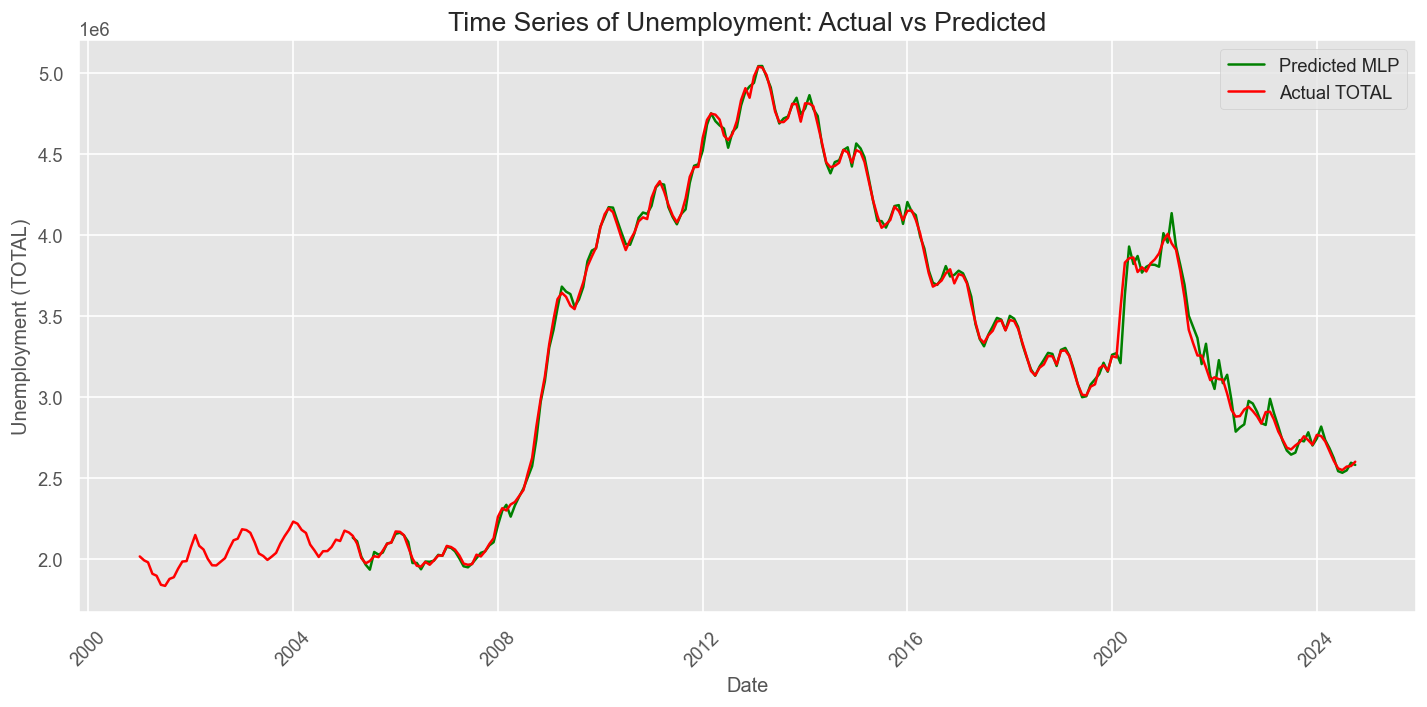

In [69]:
#Ploteamos ahora la serie corrgida del MLP
# Graficar la serie temporal
plt.figure(figsize=(12, 6))


# Graficar las predicciones MLP_pred
plt.plot(df_filtered['DATE'], df_filtered['MLP_pred_corrected']*1e6, label='Predicted MLP', color='green', linestyle='-')

# Graficar los valores reales TOTAL
plt.plot(df_ts.index, df_ts['TOTAL']*1e6, label='Actual TOTAL', color='red', linestyle='-')


# Configurar el título y etiquetas
plt.title("Time Series of Unemployment: Actual vs Predicted", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Unemployment (TOTAL)", fontsize=12)

# Rotar etiquetas del eje x para mayor legibilidad
plt.xticks(rotation=45)

# Añadir leyenda
plt.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [70]:
print(type(df_filtered['DATE'][0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [71]:
# Ahor conseguimos añadir la última fila a la filtrada para plotearla con la serie

## Prediction

# Build the dataframe with the features for November 2024
df_NOVIEMBRE= pd.DataFrame({
    'COVID': [0],  # Adjust this value if necessary
    'TOTAL_lag1': [df_ts["TOTAL"].iloc[-1]],  # Unemployment in October 2024
    'TOTAL_lag2': [df_ts["TOTAL"].iloc[-2]],  # Unemployment in September 2024
    'TOTAL_lag12': [df_ts["TOTAL"].iloc[-12]],  # Unemployment in November 2023
    'TOTAL_lag24': [df_ts["TOTAL"].iloc[-24]]  # Unemployment in November 2022
})

df_NOVIEMBRE['MLP_pred'] = MLP_fit.predict(df_NOVIEMBRE)
print(f"Unemployment prediction for November 2024: {df_NOVIEMBRE['MLP_pred'][0]} unemployed people")
df_NOVIEMBRE['DATE'] = pd.Timestamp('2024-11-01')
df_NOVIEMBRE['errors'] = error_prediccion_NOVIEMBRE/1e6
df_NOVIEMBRE['MLP_pred_corrected'] = df_NOVIEMBRE['MLP_pred'] + df_NOVIEMBRE['errors']
df_NOVIEMBRE

Unemployment prediction for November 2024: 2.6327356826156167 unemployed people


COVID  TOTAL_lag1  TOTAL_lag2  TOTAL_lag12  TOTAL_lag24  MLP_pred  \
0      0    2.602054    2.575285     2.734831      2.88138  2.632736   

        DATE    errors  MLP_pred_corrected  
0 2024-11-01 -0.033729            2.599007

In [72]:
df_filtered = pd.concat([df_filtered, df_NOVIEMBRE])

Unemployment Prediction for November 2024 (MLP+SARIMA(residuals)): 2599007 unemployment


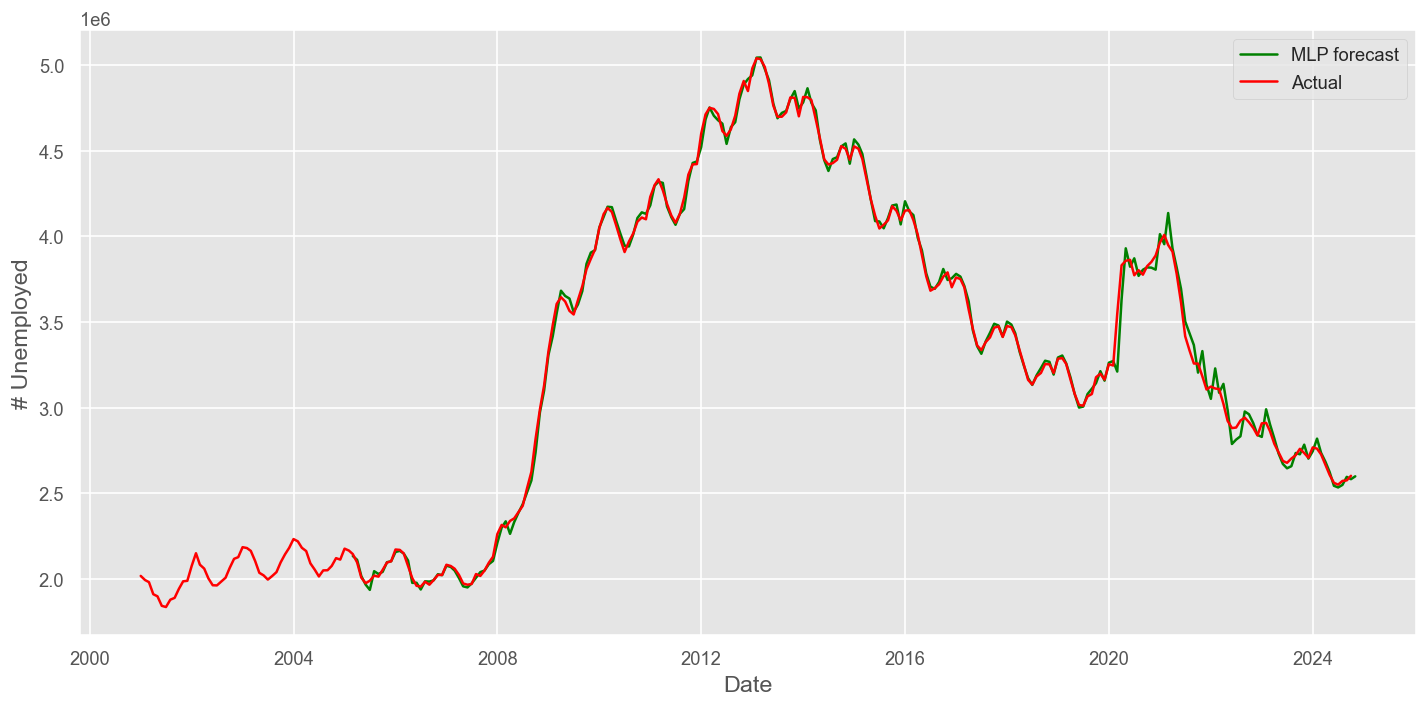

In [73]:
print(f"Unemployment Prediction for November 2024 (MLP+SARIMA(residuals)): {int(df_NOVIEMBRE.iloc[0]['MLP_pred_corrected']*1e6)} unemployment")

#Ploteamos ahora la serie corrgida del MLP
# Graficar la serie temporal
plt.figure(figsize=(12, 6))


# Graficar las predicciones MLP_pred
plt.plot(df_filtered['DATE'], df_filtered['MLP_pred_corrected']*1e6, label='MLP forecast', color='green', linestyle='-')

# Graficar los valores reales TOTAL
plt.plot(df_ts.index, df_ts['TOTAL']*1e6, label='Actual', color='red', linestyle='-')

# Destacar el valor de noviembre 2024 con un punto rojo
#plt.scatter(df_NOVIEMBRE['DATE'], df_NOVIEMBRE['MLP_pred_corrected']*1e6, color='g', label='Prediction Nov 2024', zorder=2)

# Configurar el título y etiquetas
#plt.title("Time Series of Unemployment: Actual vs Predicted", fontsize=12)
plt.xlabel("Date", fontsize=14)
plt.ylabel("# Unemployed", fontsize=14)

# Añadir leyenda
plt.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()

#### **Error comparaison (MAPE)**

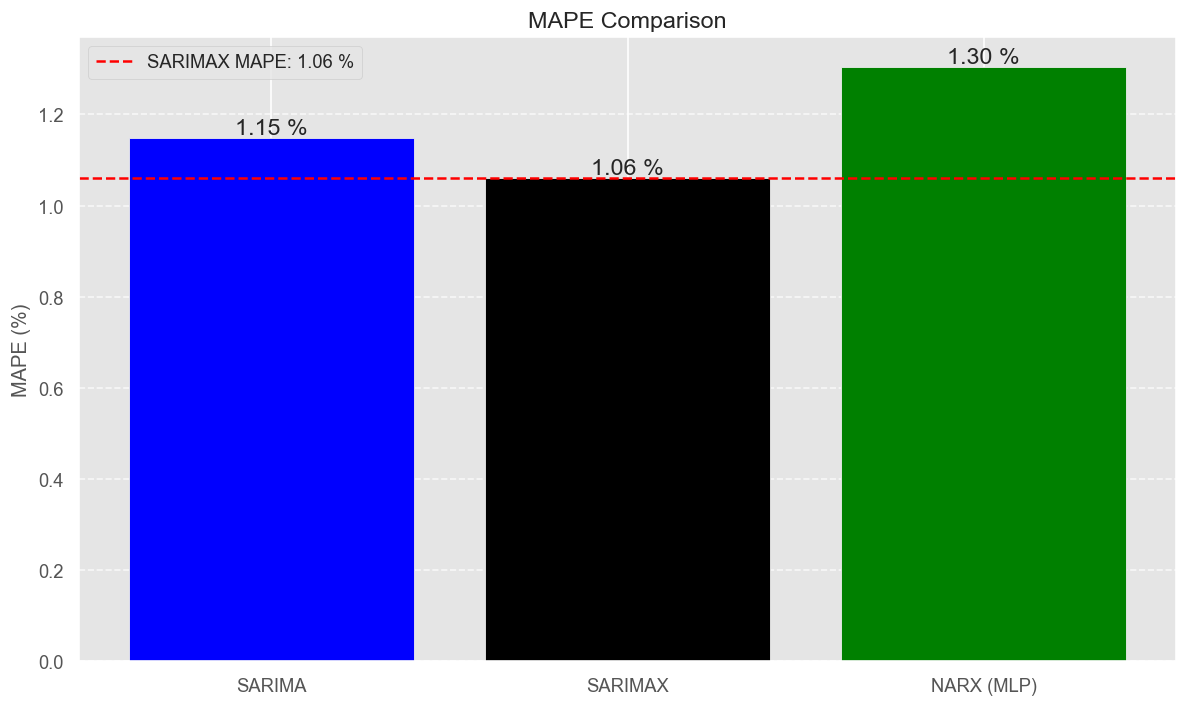

In [74]:
# Define data
labels = ['SARIMA', 'SARIMAX', 'NARX (MLP)']  # Categories for the x-axis
values = [mape_sarima, mape_sarimax, mape_mlp]  # Replace with your data
colors = ['blue', 'black', 'green']  # Colors for each bar

# Create the bar plot
plt.figure(figsize=(10, 6))  # Optional: Make the plot a bit larger
bars = plt.bar(labels, values, color=colors)

# Add labels and title
plt.ylabel('MAPE (%)', fontsize=12)  # Label for the y-axis
plt.title('MAPE Comparison', fontsize=14)  # Title of the plot

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f} %', 
             ha='center', va='bottom', fontsize=14)

# Add a horizontal dashed line at the level of 'mape_sarimax'
plt.axhline(y=mape_sarimax, color='red', linestyle='--', label=f'SARIMAX MAPE: {mape_sarimax:.2f} %')

# Add legend
plt.legend()

# Display the plot
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Optional: Add gridlines for better readability
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()